<a href="https://colab.research.google.com/github/Rahj1l/Financial-Time-series-prediction-using-transformers/blob/main/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

**DATA CLEANING**

In [ ]:
df=pd.read_csv('half_million_stock_data.csv')
df.head()

/tmp/ipython-input-574735318.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,26

,Ticker,AMZN,AMZN.1,AMZN.2,AMZN.3,AMZN.4,V,V.1,V.2,V.3,...,NEE,NEE.1,NEE.2,NEE.3,NEE.4,PFE,PFE.1,PFE.2,PFE.3,PFE.4
0,Price,Open,High,Low,Close,Volume,Open,High,Low,Close,...,Open,High,Low,Close,Volume,Open,High,Low,Close,Volume
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,4.074999809265137,4.478125095367432,3.9523439407348633,4.46875,322352000,NaN,NaN,NaN,NaN,...,2.335257384993813,2.335257384993813,2.262926614268045,2.273259401321411,4096800,11.925784836356831,12.042020618686891,11.763055040197413,11.856043815612793,12873345
3,2000-01-04,4.268750190734863,4.574999809265137,4.087500095367432,4.096875190734863,349748000,NaN,NaN,NaN,NaN,...,2.259481157575335,2.321479116167341,2.259481157575335,2.3145904541015625,5487200,11.623576090169296,11.716564896298475,11.158632807280313,11.414351463317871,14208974
4,2000-01-05,3.5250000953674316,3.7562499046325684,3.4000000953674316,3.487499952316284,769148000,NaN,NaN,NaN,NaN,...,2.2939238795629495,2.438585745841694,2.2939238795629495,2.3903651237487793,5488800,11.484088854552546,11.85604318879245,11.460841848866918,11.600324630737305,12981591


In [ ]:
import re
from sklearn.preprocessing import StandardScaler

# =========================
# CONFIG
# =========================
SEQ_LEN = 30            # transformer sequence length (days)
TEST_RATIO = 0.10      # 15% test
VAL_RATIO  = 0.10       # 15% validation (rest is train)
USE_RETURNS = True      # True: returns/log-change (recommended). False: raw levels.
VOL_FEATURE = 'logchg'  # 'logchg' (np.log1p(V).diff()) | 'ret' (pct_change) | 'raw'

In [ ]:
# =========================
# 1) LOAD + CLEANING
# =========================
new_header = []
col_to_be_removed = []

# Remove 'Adj Close' columns
for i in range(df.shape[1]):
    if df.iloc[0, i] == 'Adj Close':
        col_to_be_removed.append(i)

df.drop(df.columns[col_to_be_removed], axis=1, inplace=True)

# Check distinct columns in the first row
distinct_count_col = df.iloc[0].nunique()
print(distinct_count_col)
distinct_columns = df.iloc[0].unique()
print(distinct_columns)

# Construct column names dynamically
i = 0
for col in df.columns:
    if i % 5 != 1:
        col = col[:-2] + '_' + df.iloc[0, i]
    else:
        col = col + '_' + df.iloc[0, i]
    i += 1
    new_header.append(col)
df.columns = new_header

6
['Price' 'Open' 'High' 'Low' 'Close' 'Volume']


In [ ]:
# Drop any company that has < 5 columns
valid_cols = []
i = 1
while i < df.shape[1]:
    # Select next 5 columns (Open, High, Low, Close, Volume)
    cols = df.columns[i:i+5]
    if len(cols) == 5:
        valid_cols.extend(cols)
    else:
        print(f"Dropping company at columns {i}-{i+5} (less than 5 cols)")
    i += 5

# Keep Date + valid company columns only
df = df[[df.columns[0]] + valid_cols]


# Drop columns with NaN in whole column
i = 1
while i < df.shape[1]:
    cols = df.columns[i:i+5]
    row_vals = df.iloc[2, i:i+5]

    if row_vals.isna().any():
        df.drop(columns=cols, inplace=True)
    else:
        i += 5

# finalizing
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
df.drop(index=[0,1], inplace=True)

df.head()


,Date,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Volume,COST_Open,COST_High,COST_Low,COST_Close,...,NEE_Open,NEE_High,NEE_Low,NEE_Close,NEE_Volume,PFE_Open,PFE_High,PFE_Low,PFE_Close,PFE_Volume
2,2000-01-03,4.074999809265137,4.478125095367432,3.9523439407348633,4.46875,322352000,30.418459825301436,30.418459825301436,29.37458680452925,29.729503631591797,...,2.335257384993813,2.335257384993813,2.262926614268045,2.273259401321411,4096800,11.925784836356831,12.042020618686891,11.763055040197413,11.856043815612793,12873345
3,2000-01-04,4.268750190734863,4.574999809265137,4.087500095367432,4.096875190734863,349748000,29.708631319950097,29.771263712051187,28.03843419725438,28.10106658935547,...,2.259481157575335,2.321479116167341,2.259481157575335,2.3145904541015625,5487200,11.623576090169296,11.716564896298475,11.158632807280313,11.414351463317871,14208974
4,2000-01-05,3.5250000953674316,3.7562499046325684,3.4000000953674316,3.487499952316284,769148000,28.205447342554265,28.685628903530393,27.954917832479765,28.581241607666016,...,2.2939238795629495,2.438585745841694,2.2939238795629495,2.3903651237487793,5488800,11.484088854552546,11.85604318879245,11.460841848866918,11.600324630737305,12981591
5,2000-01-06,3.565624952316284,3.6343750953674316,3.200000047683716,3.278125047683716,375040000,28.936168756700102,29.77126742211713,28.89441382342925,29.15538215637207,...,2.393809664123502,2.4144756450204654,2.369699142851816,2.3903651237487793,2960000,11.623576347198188,12.18150770079682,11.600329332091066,12.018777847290039,11115273
6,2000-01-07,3.3499999046325684,3.5250000953674316,3.309375047683716,3.4781250953674316,210108000,29.01966262776392,31.14916305080847,28.998785172636033,31.086530685424805,...,2.404143527108414,2.469586039647577,2.383477536904044,2.4592528343200684,7999200,12.646448491595818,12.971908134210203,12.018775469117466,12.832426071166992,17962163


In [ ]:
df = df.sort_values("Date")

# Separate features and targets
features_list = []
target_list = []

# List of ticker symbols
tickers = [col.split('_')[0] for col in df.columns if '_' in col]
tickers = sorted(list(set(tickers)))

for ticker in tickers:
    # Select columns for the current ticker
    ticker_features = [f'{ticker}_Open', f'{ticker}_High', f'{ticker}_Low', f'{ticker}_Close',]
    ticker_target = f'{ticker}_Close'

    # Ensure all columns for the ticker exist in the dataframe
    if all(col in df.columns for col in ticker_features):
        features_list.append(df[ticker_features].values)
        target_list.append(df[ticker_target].values)
    else:
        print(f"Warning: Skipping ticker {ticker} as not all required columns were found.")

X = np.concatenate(features_list, axis=0)
y = np.concatenate(target_list, axis=0)


In [ ]:
# =========================
# 2) NUMERIC COERCION
# =========================
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

value_cols = [c for c in df.columns if c != 'Date']
# remove commas/spaces that can make numbers look like strings
df[value_cols] = df[value_cols].replace(r'[,\s]', '', regex=True)
# coerce to numeric
df[value_cols] = df[value_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows where ALL value columns are NaN (rare)
if len(value_cols) > 0:
    all_nan_rows = df[value_cols].isna().all(axis=1)
    if all_nan_rows.any():
        df = df[~all_nan_rows].reset_index(drop=True)


In [ ]:
# =========================
# 3) TICKERS in ORIGINAL ORDER
# =========================
pat = re.compile(r'^(.+?)_(Open|High|Low|Close|Volume)$')
tickers_order = []
seen = set()
for c in df.columns:
    m = pat.match(c)
    if m:
        tk = m.group(1)
        if tk not in seen:
            seen.add(tk)
            tickers_order.append(tk)

req = ['Open', 'High', 'Low', 'Close', 'Volume']
def has_all_cols(tk):
    return all(f'{tk}_{k}' in df.columns for k in req)

tickers = [tk for tk in tickers_order if has_all_cols(tk)]
print(f"Tickers kept (complete OHLCV, original order preserved): {len(tickers)}")
print("Tickers remaining:")

for tk in tickers:
    print(f"  {tk}")


Tickers kept (complete OHLCV, original order preserved): 80
Tickers remaining:
  AMZN
  COST
  AEP
  MDT
  APD
  USB
  CSCO
  HUM
  AMT
  SHW
  GS
  MO
  SYK
  C
  WMT
  JPM
  QCOM
  ECL
  MCD
  F
  TXN
  KR
  SO
  VZ
  CVX
  TGT
  ABT
  GILD
  WCN
  DD
  NVDA
  XOM
  LIN
  DHR
  UNH
  SBUX
  NKE
  JNJ
  BTI
  DUK
  EXC
  KO
  SRE
  CAT
  GE
  CI
  ADM
  ADBE
  INTC
  BRK-B
  MS
  CCI
  SPG
  BA
  MMM
  MOS
  AXP
  AAPL
  MSFT
  BIIB
  DIS
  HD
  BAC
  DE
  WFC
  AMGN
  CMCSA
  LMT
  CVS
  TMO
  TAP
  STZ
  ALL
  PG
  SAM
  PEP
  ORCL
  WM
  NEE
  PFE


In [ ]:
# =========================
# 4) PER-TICKER FEATURES & TARGET (leak-free)
#    Features at t; Target = next-day Close return
# =========================
def build_per_ticker(df, tk, use_returns=True, vol_feature='logchg'):
    sub = df[['Date'] + [f'{tk}_{k}' for k in req]].copy()
    sub.columns = ['Date'] + req
    sub = sub.sort_values('Date')  # keep original index for valid alignment

    feats = pd.DataFrame(index=sub.index)

    if use_returns:
        for k in ['Open', 'High', 'Low', 'Close']:
            feats[f'{k}_ret'] = sub[k].pct_change()
        if vol_feature == 'logchg':
            feats['Vol'] = np.log1p(sub['Volume']).diff()
        elif vol_feature == 'ret':
            feats['Vol'] = sub['Volume'].pct_change()
        else:
            feats['Vol'] = sub['Volume']
    else:
        feats[['Open', 'High', 'Low', 'Close']] = sub[['Open', 'High', 'Low', 'Close']]
        if vol_feature == 'logchg':
            feats['Vol'] = np.log1p(sub['Volume']).diff()
        elif vol_feature == 'ret':
            feats['Vol'] = sub['Volume'].pct_change()
        else:
            feats['Vol'] = sub['Volume']

    target = sub['Close'].pct_change().shift(-1)   # next-day return
    close_t = sub['Close']

    # Build a single boolean mask on the SAME index
    valid = (~feats.isna().any(axis=1)) & (~target.isna())

    # Use the SAME index slice for all pieces; no resets yet
    sub_v   = sub.loc[valid]
    feats_v = feats.loc[valid]
    targ_v  = target.loc[valid]
    ct_v    = close_t.loc[valid]

    # Concatenate along columns; indices align
    out = pd.concat([sub_v[['Date']], feats_v], axis=1)
    out['target_ret_next'] = targ_v.values
    out['Close_t'] = ct_v.values
    out['Ticker'] = tk

    # Reset once at the end
    out = out.reset_index(drop=True)

    assert len(out) == len(targ_v) == len(feats_v), "length mismatch after valid mask"
    return out

blocks = [build_per_ticker(df, tk, USE_RETURNS, VOL_FEATURE) for tk in tickers]


/tmp/ipython-input-1811308013.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  feats[f'{k}_ret'] = sub[k].pct_change()
/tmp/ipython-input-1811308013.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  feats[f'{k}_ret'] = sub[k].pct_change()
/tmp/ipython-input-1811308013.py:30: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  target = sub['Close'].pct_change().shift(-1)   # next-day return
/tmp/ipyt

In [ ]:
# =========================
# 5) ALIGN DATES ACROSS ALL TICKERS (panel)
# =========================
date_sets = [set(b['Date'].values) for b in blocks]
common_dates = sorted(set.intersection(*date_sets))
print(f"Common dates after feature calc: {len(common_dates)}")

# Restrict each block to common dates
blocks = [b[b['Date'].isin(common_dates)].sort_values('Date').reset_index(drop=True) for b in blocks]


Common dates after feature calc: 3185


In [ ]:
# =========================
# 6) STACK INTO A PANEL (MultiIndex columns: (Ticker, Feature))
# =========================
if USE_RETURNS:
    base_feats = ['Open_ret', 'High_ret', 'Low_ret', 'Close_ret', 'Vol']
else:
    base_feats = ['Open', 'High', 'Low', 'Close', 'Vol']

feature_panels = []
target_panels = []
close_t_panels = []

for tk, b in zip(tickers, blocks):
    feat_df = b[['Date'] + base_feats].copy().set_index('Date')
    feat_df.columns = pd.MultiIndex.from_product([[tk], base_feats], names=['Ticker', 'Feature'])
    feature_panels.append(feat_df)

    targ = b[['Date', 'target_ret_next']].set_index('Date').rename(columns={'target_ret_next': tk})
    target_panels.append(targ)

    ct = b[['Date', 'Close_t']].set_index('Date').rename(columns={'Close_t': tk})
    close_t_panels.append(ct)

X_panel = pd.concat(feature_panels, axis=1).sort_index()
Y_panel = pd.concat(target_panels, axis=1).sort_index()
Close_t_panel = pd.concat(close_t_panels, axis=1).sort_index()

assert (X_panel.index.equals(Y_panel.index)) and (X_panel.index.equals(Close_t_panel.index))

dates_all = X_panel.index.values
num_days = len(dates_all)
num_tickers = len(tickers)
num_feats = len(base_feats)
print(f"Panel shape (days x (tickers*features)): {X_panel.shape} = {num_days} x ({num_tickers}*{num_feats})")

# Flatten ticker-feature MultiIndex to a single axis in consistent original-ticker order
flat_feature_cols = []
for tk in tickers:
    for f in base_feats:
        flat_feature_cols.append((tk, f))
X_flat = X_panel.reindex(columns=pd.MultiIndex.from_tuples(flat_feature_cols, names=['Ticker','Feature']))

X_mat = X_flat.values.astype(np.float64)              # (D, T*F)
Y_mat = Y_panel[tickers].values.astype(np.float64)    # (D, T)
Close_mat = Close_t_panel[tickers].values.astype(np.float64)


Panel shape (days x (tickers*features)): (3185, 400) = 3185 x (80*5)


In [ ]:
# =========================
# 7) BUILD SEQUENCES FOR TRANSFORMER
# =========================
def make_sequences(X_mat, Y_mat, seq_len):
    X_seq, Y_seq = [], []
    for i in range(seq_len - 1, len(X_mat)):
        X_seq.append(X_mat[i - seq_len + 1:i + 1, :])  # window ending at i
        Y_seq.append(Y_mat[i, :])                      # label at date i (next-day return)
    return np.array(X_seq), np.array(Y_seq)

X_seq, y_seq = make_sequences(X_mat, Y_mat, SEQ_LEN)
seq_days = dates_all[SEQ_LEN - 1:]
print(f"Sequences: X={X_seq.shape}, y={y_seq.shape}")


Sequences: X=(3156, 30, 400), y=(3156, 80)


In [ ]:
# =========================
# 8) CHRONOLOGICAL SPLIT (train/val/test)
# =========================
n = len(X_seq)
n_test = int(n * TEST_RATIO)
n_val  = int(n * VAL_RATIO)
n_train = n - n_val - n_test

X_train, X_val, X_test = X_seq[:n_train], X_seq[n_train:n_train+n_val], X_seq[n_train+n_val:]
y_train, y_val, y_test = y_seq[:n_train], y_seq[n_train:n_train+n_val], y_seq[n_train+n_val:]
dates_train, dates_val, dates_test = seq_days[:n_train], seq_days[n_train:n_train+n_val], seq_days[n_train+n_val:]

print(f"Split sizes: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")


Split sizes: train=2526, val=315, test=315


In [ ]:
# =========================
# 9) SCALING, channel-wise
# =========================
train_2d = X_train.reshape(-1, X_train.shape[-1])   # (n_train*SEQ_LEN, channels)
val_2d   = X_val.reshape(-1,   X_val.shape[-1])
test_2d  = X_test.reshape(-1,  X_test.shape[-1])

feature_scaler = StandardScaler()
feature_scaler.fit(train_2d)

X_train_scaled = feature_scaler.transform(train_2d).reshape(X_train.shape)
X_val_scaled   = feature_scaler.transform(val_2d).reshape(X_val.shape)
X_test_scaled  = feature_scaler.transform(test_2d).reshape(X_test.shape)

print("\n=== TRAIN scaled channel stats (approx mean~0, std~1) ===")
scaled_check = X_train_scaled.reshape(-1, X_train_scaled.shape[-1])
print("mean (first 10 chans):", np.round(scaled_check.mean(axis=0), 6)[:10])
print("std  (first 10 chans):", np.round(scaled_check.std(axis=0, ddof=0), 6)[:10])




=== TRAIN scaled channel stats (approx mean~0, std~1) ===
mean (first 10 chans): [ 0.  0. -0.  0. -0.  0.  0. -0.  0. -0.]
std  (first 10 chans): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# =========================
# 10) OUTPUTS
# =========================
print("\nFinal tensors:")
print("X_train_scaled:", X_train_scaled.shape, "| y_train:", y_train.shape)
print("X_val_scaled  :", X_val_scaled.shape,   "| y_val  :", y_val.shape)
print("X_test_scaled :", X_test_scaled.shape,  "| y_test :", y_test.shape)
print("Num tickers:", num_tickers, "| Features per ticker:", num_feats, "| Seq len:", SEQ_LEN)



Final tensors:
X_train_scaled: (2526, 30, 400) | y_train: (2526, 80)
X_val_scaled  : (315, 30, 400) | y_val  : (315, 80)
X_test_scaled : (315, 30, 400) | y_test : (315, 80)
Num tickers: 80 | Features per ticker: 5 | Seq len: 30


##**DATA PREPROCESSING**

In [ ]:
# =========================
# INSPECTION SECTION
# =========================

print("\n" + "="*60)
print("CLEANED ORIGINAL DATAFRAME (df)")
print("="*60)
print(df.info())
print("\nFirst 5 rows of df:")
print(df.head(5))

# Show a few columns (first ticker only for clarity)
first_ticker = tickers[0]
print(f"\nColumns for first ticker ({first_ticker}):")
print([c for c in df.columns if first_ticker in c][:10])


CLEANED ORIGINAL DATAFRAME (df)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3187 entries, 2 to 3188
Columns: 401 entries, Date to PFE_Volume
dtypes: datetime64[ns](1), float64(383), int64(17)
memory usage: 9.8 MB
None

First 5 rows of df:
        Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
2 2000-01-03   4.075000   4.478125  3.952344    4.468750    322352000   
3 2000-01-04   4.268750   4.575000  4.087500    4.096875    349748000   
4 2000-01-05   3.525000   3.756250  3.400000    3.487500    769148000   
5 2000-01-06   3.565625   3.634375  3.200000    3.278125    375040000   
6 2000-01-07   3.350000   3.525000  3.309375    3.478125    210108000   

   COST_Open  COST_High   COST_Low  COST_Close  ...  NEE_Open  NEE_High  \
2  30.418460  30.418460  29.374587   29.729504  ...  2.335257  2.335257   
3  29.708631  29.771264  28.038434   28.101067  ...  2.259481  2.321479   
4  28.205447  28.685629  27.954918   28.581242  ...  2.293924  2.438586   
5  28.936169  2

In [ ]:
# =========================
# INSPECT FEATURE PANEL (after alignment)
# =========================
print("\n" + "="*60)
print("FEATURE PANEL (X_panel)")
print("="*60)
print(f"Shape: {X_panel.shape}  (days x tickers*features)")
print("Index sample:", X_panel.index[:5].tolist())
print("Columns (first 10):", X_panel.columns[:10])
print("\nSample rows:")
display(X_panel.head(3))  # if running in notebook, else use print(X_panel.head(3))


FEATURE PANEL (X_panel)
Shape: (3185, 400)  (days x tickers*features)
Index sample: [Timestamp('2000-01-04 00:00:00'), Timestamp('2000-01-05 00:00:00'), Timestamp('2000-01-06 00:00:00'), Timestamp('2000-01-07 00:00:00'), Timestamp('2000-01-10 00:00:00')]
Columns (first 10): MultiIndex([('AMZN',  'Open_ret'),
            ('AMZN',  'High_ret'),
            ('AMZN',   'Low_ret'),
            ('AMZN', 'Close_ret'),
            ('AMZN',       'Vol'),
            ('COST',  'Open_ret'),
            ('COST',  'High_ret'),
            ('COST',   'Low_ret'),
            ('COST', 'Close_ret'),
            ('COST',       'Vol')],
           names=['Ticker', 'Feature'])

Sample rows:


Ticker          AMZN                                              COST  \
Feature     Open_ret  High_ret   Low_ret Close_ret       Vol  Open_ret   
Date                                                                     
2000-01-04  0.047546  0.021633  0.034196 -0.083217  0.081569 -0.023335   
2000-01-05 -0.174231 -0.178962 -0.168196 -0.148741  0.788071 -0.050598   
2000-01-06  0.011525 -0.032446 -0.058824 -0.060036 -0.718251  0.025907   

Ticker                                              ...       NEE            \
Feature     High_ret   Low_ret Close_ret       Vol  ...  Open_ret  High_ret   
Date                                                ...                       
2000-01-04 -0.021276 -0.045487 -0.054775 -0.056822  ... -0.032449 -0.005900   
2000-01-05 -0.036466 -0.002979  0.017087  0.300185  ...  0.015244  0.050445   
2000-01-06  0.037846  0.033608  0.020088 -0.067594  ...  0.043544 -0.009887   

Ticker                                         PFE                      \
Feature      Low_ret Close_ret       Vol  Open_ret  High_ret   Low_ret   
Date                                                                     
2000-01-04 -0.001523  0.018181  0.292212 -0.025341 -0.027027 -0.051383   
2000-01-05  0.015244  0.032738  0.000292 -0.012000  0.011904  0.027083   
2000-01-06  0.033033  0.000000 -0.617520  0.012146  0.027451  0.012171   

Ticker                          
Feature    Close_ret       Vol  
Date                            
2000-01-04 -0.037255  0.098715  
2000-01-05  0.016293 -0.090341  
2000-01-06  0.036073 -0.155212  

[3 rows x 400 columns]

In [ ]:
# =========================
# INSPECT TARGET PANEL
# =========================
print("\n" + "="*60)
print("TARGET PANEL (Y_panel)")
print("="*60)
print(f"Shape: {Y_panel.shape}  (days x tickers)")
print("Tickers sample:", Y_panel.columns[:10].tolist())
print("\nSample rows:")
print(Y_panel.head(3))


TARGET PANEL (Y_panel)
Shape: (3185, 80)  (days x tickers)
Tickers sample: ['AMZN', 'COST', 'AEP', 'MDT', 'APD', 'USB', 'CSCO', 'HUM', 'AMT', 'SHW']

Sample rows:
                AMZN      COST       AEP       MDT       APD       USB  \
Date                                                                     
2000-01-04 -0.148741  0.017087  0.037328  0.062827  0.005894 -0.022082   
2000-01-05 -0.060036  0.020088  0.005683  0.037543  0.066407  0.077419   
2000-01-06  0.061010  0.066236  0.013182  0.111841  0.069597  0.038922   

                CSCO       HUM       AMT       SHW  ...       TAP       STZ  \
Date                                                ...                       
2000-01-04 -0.003063  0.024590  0.030172  0.003226  ...  0.047440  0.033898   
2000-01-05 -0.016595  0.040000 -0.010461  0.016077  ... -0.011919  0.039092   
2000-01-06  0.058750  0.076923  0.054968 -0.012658  ...  0.021713  0.029126   

                 ALL        PG       SAM       PEP      ORCL        W

In [ ]:
# =========================
# TRAIN / VAL / TEST PREVIEW
# =========================
def describe_split(name, X, y, dates):
    print(f"\n{name} split:")
    print(f"  X shape: {X.shape}, y shape: {y.shape}")
    print(f"  Date range: {dates[0]} → {dates[-1]}")
    print(f"  Example sequence window [0]:")
    print("    Features (flattened first 10 values):", np.round(X[0].reshape(-1)[:10], 3))
    print("    Target first 5 tickers:", np.round(y[0][:5], 5))

describe_split("TRAIN", X_train_scaled, y_train, dates_train)
describe_split("VAL",   X_val_scaled,   y_val,   dates_val)
describe_split("TEST",  X_test_scaled,  y_test,  dates_test)


TRAIN split:
  X shape: (2526, 30, 400), y shape: (2526, 80)
  Date range: 2000-02-15T00:00:00.000000000 → 2010-03-03T00:00:00.000000000
  Example sequence window [0]:
    Features (flattened first 10 values): [ 1.116  0.554  0.857 -2.017  0.19  -1.063 -1.119 -2.173 -2.523 -0.132]
    Target first 5 tickers: [-0.04234 -0.03291 -0.01996 -0.02613 -0.03448]

VAL split:
  X shape: (315, 30, 400), y shape: (315, 80)
  Date range: 2010-03-04T00:00:00.000000000 → 2011-06-01T00:00:00.000000000
  Example sequence window [0]:
    Features (flattened first 10 values): [-0.001 -0.24  -0.041  0.134  0.219 -0.285 -0.085 -0.238 -0.605 -0.604]
    Target first 5 tickers: [ 0.00296 -0.00197  0.01003  0.01517  0.0224 ]

TEST split:
  X shape: (315, 30, 400), y shape: (315, 80)
  Date range: 2011-06-02T00:00:00.000000000 → 2012-08-29T00:00:00.000000000
  Example sequence window [0]:
    Features (flattened first 10 values): [0.415 0.799 0.704 0.65  0.999 0.234 1.009 0.567 1.088 0.749]
    Target first 5

In [ ]:
# =========================
# CHECK 1 SEQUENCE VISUALLY
# =========================
seq_idx = 0
print("\nExample sequence index:", seq_idx)
print("Sequence dates:", seq_days[seq_idx-SEQ_LEN+1:seq_idx+1] if seq_idx>=SEQ_LEN else seq_days[:SEQ_LEN])
print(f"Flattened shape: {X_train_scaled[seq_idx].shape} = (seq_len, {num_tickers*num_feats})")
print("First ticker feature segment for that window:")
first_ticker_slice = slice(0, num_feats)
print(pd.DataFrame(X_train_scaled[seq_idx][:, first_ticker_slice],
                   columns=[f"{tickers[0]}_{f}" for f in base_feats]).head())



Example sequence index: 0
Sequence dates: ['2000-02-15T00:00:00.000000000' '2000-02-16T00:00:00.000000000'
 '2000-02-17T00:00:00.000000000' '2000-02-18T00:00:00.000000000'
 '2000-02-22T00:00:00.000000000' '2000-02-23T00:00:00.000000000'
 '2000-02-24T00:00:00.000000000' '2000-02-25T00:00:00.000000000'
 '2000-02-28T00:00:00.000000000' '2000-02-29T00:00:00.000000000'
 '2000-03-01T00:00:00.000000000' '2000-03-02T00:00:00.000000000'
 '2000-03-03T00:00:00.000000000' '2000-03-06T00:00:00.000000000'
 '2000-03-07T00:00:00.000000000' '2000-03-08T00:00:00.000000000'
 '2000-03-09T00:00:00.000000000' '2000-03-10T00:00:00.000000000'
 '2000-03-13T00:00:00.000000000' '2000-03-14T00:00:00.000000000'
 '2000-03-15T00:00:00.000000000' '2000-03-16T00:00:00.000000000'
 '2000-03-17T00:00:00.000000000' '2000-03-20T00:00:00.000000000'
 '2000-03-21T00:00:00.000000000' '2000-03-22T00:00:00.000000000'
 '2000-03-23T00:00:00.000000000' '2000-03-24T00:00:00.000000000'
 '2000-03-27T00:00:00.000000000' '2000-03-28T00

In [ ]:
df.head()

,Date,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Volume,COST_Open,COST_High,COST_Low,COST_Close,...,NEE_Open,NEE_High,NEE_Low,NEE_Close,NEE_Volume,PFE_Open,PFE_High,PFE_Low,PFE_Close,PFE_Volume
2,2000-01-03,4.075000,4.478125,3.952344,4.468750,322352000,30.418460,30.418460,29.374587,29.729504,...,2.335257,2.335257,2.262927,2.273259,4096800.0,11.925785,12.042021,11.763055,11.856044,12873345.0
3,2000-01-04,4.268750,4.575000,4.087500,4.096875,349748000,29.708631,29.771264,28.038434,28.101067,...,2.259481,2.321479,2.259481,2.314590,5487200.0,11.623576,11.716565,11.158633,11.414351,14208974.0
4,2000-01-05,3.525000,3.756250,3.400000,3.487500,769148000,28.205447,28.685629,27.954918,28.581242,...,2.293924,2.438586,2.293924,2.390365,5488800.0,11.484089,11.856043,11.460842,11.600325,12981591.0
5,2000-01-06,3.565625,3.634375,3.200000,3.278125,375040000,28.936169,29.771267,28.894414,29.155382,...,2.393810,2.414476,2.369699,2.390365,2960000.0,11.623576,12.181508,11.600329,12.018778,11115273.0
6,2000-01-07,3.350000,3.525000,3.309375,3.478125,210108000,29.019663,31.149163,28.998785,31.086531,...,2.404144,2.469586,2.383478,2.459253,7999200.0,12.646448,12.971908,12.018775,12.832426,17962163.0


In [ ]:
# =========================
# Presence checks
# =========================
req = [
    'tickers','base_feats','X_panel','Y_panel','Close_t_panel',
    'X_train_scaled','X_val_scaled','X_test_scaled','y_train','y_val','y_test',
    'SEQ_LEN','num_tickers','num_feats','dates_train','dates_val','dates_test','seq_days',
    'feature_scaler'
]
missing = [v for v in req if v not in globals()]
if missing:
    raise RuntimeError(f"Missing variables from preprocessing: {missing}")
else:
    print("All good.")

All good.


In [ ]:
# =========================
# Helpers
# =========================
def channel_starts(num_tickers, num_feats):
    return np.array([i*num_feats for i in range(num_tickers)], dtype=int)

def ticker_block(ticker_idx, num_feats):
    start = ticker_idx * num_feats
    return slice(start, start + num_feats)

def set_sparse_ticker_xticks(ax, tickers, step=None):
    if step is None:
        step = max(1, len(tickers)//20)
    xs = np.arange(0, len(tickers), step)
    ax.set_xticks(xs)
    ax.set_xticklabels([tickers[i] for i in xs], rotation=90)

def describe(txt):
    print(f"{txt}\n")

In [ ]:
import matplotlib.pyplot as plt
# ======================================================================
# A) PREPROCESSING-LEVEL PLOTS (no scaling needed)
# ======================================================================
def plot_target_distributions(y_train, y_val, y_test):
    plt.figure()
    plt.hist(y_train.reshape(-1), bins=100, alpha=0.7, label='Train: next-day close returns')
    plt.hist(y_val.reshape(-1),   bins=100, alpha=0.7, label='Val: next-day close returns')
    plt.hist(y_test.reshape(-1),  bins=100, alpha=0.7, label='Test: next-day close returns')
    plt.title('Distribution of next-day close returns (all tickers)')
    plt.xlabel('Return (Close_{t+1}/Close_t - 1)')
    plt.ylabel('Frequency (samples)')
    plt.legend()
    plt.tight_layout(); plt.show()
    describe("Histogram of next-day close returns for each split. Helps spot fat tails, skew, "
             "and whether train/val/test distributions align.")

def plot_cross_ticker_corr(y_train, tickers):
    corr = np.corrcoef(y_train.T)
    fig, ax = plt.subplots()
    im = ax.imshow(corr, aspect='auto', interpolation='nearest')
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Correlation coefficient')
    ax.set_title('Cross-ticker correlation of next-day returns (Train)')
    ax.set_xlabel('Ticker index (original order)')
    ax.set_ylabel('Ticker index (original order)')
    step = max(1, len(tickers)//20)
    idxs = list(range(0, len(tickers), step))
    ax.set_xticks(idxs); ax.set_yticks(idxs)
    ax.set_xticklabels([tickers[i] for i in idxs], rotation=90)
    ax.set_yticklabels([tickers[i] for i in idxs])
    plt.tight_layout(); plt.show()
    describe("Heatmap of correlations between tickers’ next-day returns on the TRAIN set. "
             "Bright = move together; dark = move inversely; near zero = independent.")

def plot_per_ticker_feature_target_corr(X_panel, Y_panel, tickers, base_feats, sample_tickers=None):
    idx = pd.IndexSlice
    if sample_tickers is None:
        sample_tickers = tickers[:min(6,len(tickers))]
    for tk in sample_tickers:
        try:
            x_df = X_panel.loc[:, idx[tk, base_feats]].copy()
            x_df.columns = [c[1] for c in x_df.columns.to_list()]
        except Exception:
            x_df = X_panel.xs(tk, axis=1, level='Ticker')
            missing = [f for f in base_feats if f not in x_df.columns]
            if missing:
                print(f"Skip {tk}: missing features {missing}"); continue
            x_df = x_df[base_feats].copy()
        if tk not in Y_panel.columns:
            print(f"Skip {tk}: no target in Y_panel"); continue
        y_s = Y_panel[tk]
        df_aligned = pd.concat([x_df, y_s.rename('target_ret_next')], axis=1).dropna()
        if df_aligned.empty:
            print(f"Skip {tk}: no overlap after dropna"); continue
        cors = [df_aligned[f].corr(df_aligned['target_ret_next']) for f in base_feats]
        fig, ax = plt.subplots()
        ax.bar(np.arange(len(base_feats)), cors)
        ax.set_title(f'Corr(Feature_t, Next-day return) - {tk}')
        ax.set_xlabel('Feature at time t'); ax.set_ylabel('Pearson correlation')
        ax.set_xticks(np.arange(len(base_feats))); ax.set_xticklabels(base_feats)
        for i, v in enumerate(cors): ax.text(i, v if v>=0 else v, f'{v:.6f}', ha='center', va='bottom' if v>=0 else 'top')
        plt.tight_layout(); plt.show()
        describe(f"For {tk}, correlation between each feature at day t and the ticker’s next-day return. "
                 "Shows which inputs tend to move with (or against) the target.")

def plot_rolling_corr(Y_panel, ticker_a, ticker_b, window=60):
    df2 = Y_panel[[ticker_a, ticker_b]].dropna()
    roll = df2[ticker_a].rolling(window).corr(df2[ticker_b])
    plt.figure()
    plt.plot(df2.index, roll, label=f'Rolling corr ({window} days): {ticker_a} vs {ticker_b}')
    plt.title(f'Rolling correlation of next-day returns: {ticker_a} vs {ticker_b}')
    plt.xlabel('Date (trading days)'); plt.ylabel('Correlation coefficient')
    plt.legend(); plt.tight_layout(); plt.show()
    describe(f"Time-varying correlation of next-day returns between {ticker_a} and {ticker_b} "
             f"over a {window}-day window. Useful for regime changes.")



In [ ]:
# ======================================================================
# B) SCALED vs UNSCALED: One window (side-by-side in sequence)
# ======================================================================
def inverse_window(X_window_scaled, feature_scaler):
    flat = X_window_scaled.reshape(-1, X_window_scaled.shape[-1])
    unscaled = feature_scaler.inverse_transform(flat).reshape(X_window_scaled.shape)
    return unscaled

def plot_sequence_heatmap_unscaled(X_window_unscaled, tickers, base_feats,
                                   label_first_k_tickers=10, zoom_tickers=None,
                                   title_prefix='UNSCALED', vmax=None, vmin=None):
    num_tickers = len(tickers); num_feats = len(base_feats)
    seq_len, channels = X_window_unscaled.shape

    if zoom_tickers is not None:
        chosen_idxs = zoom_tickers
        chosen_labels = [tickers[i] for i in zoom_tickers]
    else:
        chosen_idxs = list(range(min(label_first_k_tickers, num_tickers)))
        chosen_labels = tickers[:min(label_first_k_tickers, num_tickers)]

    start = chosen_idxs[0] * num_feats
    end   = (chosen_idxs[-1] + 1) * num_feats
    subset = X_window_unscaled[:, start:end]

    fig, ax = plt.subplots(figsize=(max(10, len(chosen_idxs)*1.2), 6))
    im = ax.imshow(subset, aspect='auto', interpolation='nearest',
                   vmin=vmin, vmax=vmax, cmap='viridis')
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Raw feature value')

    ax.set_title(f'{title_prefix} feature window heatmap\n'
                 f'Rows = {seq_len} past trading days, Cols = {len(chosen_idxs)} tickers × {num_feats} features each')
    ax.set_xlabel('Ticker × Feature block'); ax.set_ylabel('Time step in window (0 = oldest)')

    for i in range(len(chosen_idxs)-1):
        ax.axvline((i+1)*num_feats - 0.5, color='white', linestyle='--', linewidth=0.8)

    centers = np.arange(num_feats/2, len(chosen_idxs)*num_feats, num_feats)
    ax.set_xticks(centers); ax.set_xticklabels(chosen_labels, rotation=90, fontsize=9)

    plt.tight_layout(); plt.show()
    describe("UNSCALED heatmap of a single input window. Raw magnitudes can dominate the color scale; "
             "useful to see actual values and outliers before standardization.")

def plot_sequence_heatmap_scaled(X_window_scaled, tickers, base_feats,
                                 label_first_k_tickers=10, zoom_tickers=None,
                                 vmax=3, vmin=-3):
    num_tickers = len(tickers); num_feats = len(base_feats)
    seq_len, channels = X_window_scaled.shape

    if zoom_tickers is not None:
        chosen_idxs = zoom_tickers
        chosen_labels = [tickers[i] for i in zoom_tickers]
    else:
        chosen_idxs = list(range(min(label_first_k_tickers, num_tickers)))
        chosen_labels = tickers[:min(label_first_k_tickers, num_tickers)]

    start = chosen_idxs[0] * num_feats
    end   = (chosen_idxs[-1] + 1) * num_feats
    subset = X_window_scaled[:, start:end]

    fig, ax = plt.subplots(figsize=(max(10, len(chosen_idxs)*1.2), 6))
    im = ax.imshow(subset, aspect='auto', interpolation='nearest',
                   vmin=vmin, vmax=vmax, cmap='viridis')
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Scaled feature value (z-score)')

    ax.set_title(f'SCALED feature window heatmap\n'
                 f'Rows = {seq_len} past trading days, Cols = {len(chosen_idxs)} tickers × {num_feats} features each')
    ax.set_xlabel('Ticker × Feature block'); ax.set_ylabel('Time step in window (0 = oldest)')

    for i in range(len(chosen_idxs)-1):
        ax.axvline((i+1)*num_feats - 0.5, color='white', linestyle='--', linewidth=0.8)

    centers = np.arange(num_feats/2, len(chosen_idxs)*num_feats, num_feats)
    ax.set_xticks(centers); ax.set_xticklabels(chosen_labels, rotation=90, fontsize=9)

    plt.tight_layout(); plt.show()
    describe("SCALED heatmap of the same window. Colors show deviations from the TRAIN mean (z-scores). "
             "Makes patterns comparable across tickers/features.")



In [ ]:
# ======================================================================
# C) TRAIN-WIDE SCALED STATS
# ======================================================================
def plot_channel_stats_scaled(X_train_scaled):
    train_2d = X_train_scaled.reshape(-1, X_train_scaled.shape[-1])
    chan_mean = train_2d.mean(axis=0)
    chan_std  = train_2d.std(axis=0, ddof=0)

    plt.figure()
    plt.plot(chan_mean, label='Mean per channel (≈ 0)')
    plt.title('Channel-wise mean (TRAIN, scaled)')
    plt.xlabel('Channel index (ticker×feature)'); plt.ylabel('Mean (z-score)')
    plt.legend(); plt.tight_layout(); plt.show()
    describe("Per-channel mean across the entire TRAIN set after scaling. "
             "Most values should sit near 0 if StandardScaler was applied correctly.")

    plt.figure()
    plt.plot(chan_std, label='Std per channel (≈ 1)')
    plt.title('Channel-wise std (TRAIN, scaled)')
    plt.xlabel('Channel index (ticker×feature)'); plt.ylabel('Std (z-score)')
    plt.legend(); plt.tight_layout(); plt.show()
    describe("Per-channel standard deviation after scaling. Values should be close to 1; "
             "large deviations may indicate unusual variance or many repeats/zeros.")

def plot_split_sizes(X_train_scaled, X_val_scaled, X_test_scaled):
    sizes = [len(X_train_scaled), len(X_val_scaled), len(X_test_scaled)]
    plt.figure()
    plt.bar(['Train sequences','Val sequences','Test sequences'], sizes)
    plt.title('Number of sequences per split'); plt.ylabel('Count')
    for i, v in enumerate(sizes): plt.text(i, v, str(v), ha='center', va='bottom')
    plt.tight_layout(); plt.show()
    describe("Counts of sequence windows in each split. Sanity check for your chronological splitting.")

In [ ]:
# ======================================================================
# D) UNSCALED vs SCALED lines for last 120 days (first ticker)
# ======================================================================
def plot_first_ticker_raw_features_over_time(X_panel, tickers, base_feats, days=120):
    first_tk = tickers[0]
    tk_cols = [c for c in X_panel.columns if c[0] == first_tk]
    tk_df = X_panel[tk_cols].copy()
    tk_df.columns = [c[1] for c in tk_df.columns]
    tk_df = tk_df.tail(days)
    plt.figure()
    for f in base_feats:
        if f in tk_df.columns:
            plt.plot(tk_df.index.values, tk_df[f].values, label=f'{first_tk} - {f}')
    plt.title(f'{first_tk}: last {days} trading days (pre-scaling features)')
    plt.xlabel('Date'); plt.ylabel('Raw feature value'); plt.legend()
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()
    describe(f"UNSCALED feature lines for {first_tk} over the last {days} trading days. "
             "Shows real magnitudes and any outliers before standardization.")

def plot_first_ticker_scaled_features_over_time(X_panel, tickers, base_feats, feature_scaler, days=120):
    """
    Scale the same first-ticker panel using the TRAIN StandardScaler's channel stats,
    then plot z-scored lines for apples-to-apples comparison vs raw lines.
    """
    first_tk_idx = 0
    first_tk = tickers[first_tk_idx]
    tk_cols = [c for c in X_panel.columns if c[0] == first_tk]
    tk_df = X_panel[tk_cols].copy()
    tk_df.columns = [c[1] for c in tk_df.columns]  # feature names
    tk_df = tk_df.tail(days)

    # Apply per-channel z-score using the TRAIN scaler stats for this ticker block
    means = feature_scaler.mean_
    scales = feature_scaler.scale_
    offset = first_tk_idx * len(base_feats)
    Z = {}
    for i, f in enumerate(base_feats):
        ch = offset + i
        Z[f] = (tk_df[f].values - means[ch]) / (scales[ch] if scales[ch] != 0 else 1.0)
    Z = pd.DataFrame(Z, index=tk_df.index)

    plt.figure()
    for f in base_feats:
        plt.plot(Z.index.values, Z[f].values, label=f'{first_tk} - {f} (z-score)')
    plt.title(f'{first_tk}: last {days} trading days (SCALED features)')
    plt.xlabel('Date'); plt.ylabel('Scaled value (z-score)'); plt.legend()
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()
    describe(f"SCALED feature lines for {first_tk} over the last {days} trading days. "
             "Now all features are on a comparable z-score scale (mean≈0, std≈1).")

In [ ]:
# ======================================================================
# E) SCALED VS UNSCALED WINDOW TRAECS
# ======================================================================

def inverse_window(X_window_scaled, feature_scaler):

    flat = X_window_scaled.reshape(-1, X_window_scaled.shape[-1])
    unscaled = feature_scaler.inverse_transform(flat).reshape(X_window_scaled.shape)
    return unscaled

def plot_ticker_window_traces_scaled(X_window_scaled, ticker_idx, tickers, base_feats, num_feats):
    if ticker_idx < 0 or ticker_idx >= len(tickers):
        raise IndexError(f"ticker_idx out of range: 0..{len(tickers)-1}")
    start = ticker_idx * num_feats
    end   = start + num_feats
    block = X_window_scaled[:, start:end]  # (SEQ_LEN, num_feats)

    plt.figure()
    for i, f in enumerate(base_feats):
        plt.plot(np.arange(block.shape[0]), block[:, i], label=f'{tickers[ticker_idx]} - {f}')
    plt.title(f'SCALED feature traces within one window - {tickers[ticker_idx]}')
    plt.xlabel('Time step in window (0 = oldest)')
    plt.ylabel('Scaled value (z-score)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(" Scaled traces: z-scores after StandardScaler (fit on TRAIN). "
          "Different features are comparable across magnitude.\n")

def plot_ticker_window_traces_unscaled(X_window_scaled, ticker_idx, tickers, base_feats, num_feats, feature_scaler):
    if ticker_idx < 0 or ticker_idx >= len(tickers):
        raise IndexError(f"ticker_idx out of range: 0..{len(tickers)-1}")
    X_window_unscaled = inverse_window(X_window_scaled, feature_scaler)

    start = ticker_idx * num_feats
    end   = start + num_feats
    block = X_window_unscaled[:, start:end]  # (SEQ_LEN, num_feats)

    plt.figure()
    for i, f in enumerate(base_feats):
        plt.plot(np.arange(block.shape[0]), block[:, i], label=f'{tickers[ticker_idx]} - {f}')
    plt.title(f'UNSCALED feature traces within one window - {tickers[ticker_idx]}')
    plt.xlabel('Time step in window (0 = oldest)')
    plt.ylabel('Raw feature value')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(" Unscaled traces: raw magnitudes before standardization. "
          "Useful to see outliers and actual units per feature.\n")

In [ ]:
# ======================================================================
# F) MISC. DIAGNOSTICS
# ======================================================================
def plot_feature_feature_corr_for_ticker(X_panel, ticker, base_feats):

    block = X_panel.xs(ticker, axis=1, level='Ticker')
    block = block[base_feats].dropna()
    C = block.corr().values
    fig, ax = plt.subplots()
    im = ax.imshow(C, interpolation='nearest', aspect='auto')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Correlation')
    ax.set_title(f'Feature↔Feature correlation at time t - {ticker}')
    ax.set_xticks(np.arange(len(base_feats))); ax.set_xticklabels(base_feats, rotation=0)
    ax.set_yticks(np.arange(len(base_feats))); ax.set_yticklabels(base_feats)
    plt.tight_layout(); plt.show()
    describe(f"Correlation among {ticker}'s input features at time t. Helps detect redundant features "
             "or unusually strong relationships (e.g., Open/Close nearly identical).")

def plot_autocorr_targets(Y_panel, sample_tickers=None, max_lag=20):

    if sample_tickers is None:
        sample_tickers = tickers[:min(4, len(tickers))]
    for tk in sample_tickers:
        s = Y_panel[tk].dropna().values
        ac = []
        for lag in range(1, max_lag+1):
            s1 = s[:-lag]; s2 = s[lag:]
            if len(s1) < 3: ac.append(np.nan); continue
            ac.append(np.corrcoef(s1, s2)[0,1])
        plt.figure()
        plt.bar(np.arange(1, max_lag+1), ac, label=f'{tk} autocorr')
        plt.title(f'Autocorrelation of next-day returns - {tk}')
        plt.xlabel('Lag (days)'); plt.ylabel('Correlation'); plt.legend()
        plt.tight_layout(); plt.show()
        describe(f"Autocorrelation of {tk}'s next-day returns for lags 1..{max_lag}. "
                 "Persistent positive bars suggest momentum; negatives suggest mean reversion.")

def plot_close_prices(Close_t_panel, tickers, last_days=300):
    sample_tickers = tickers[:min(5, len(tickers))]
    close_df = Close_t_panel[sample_tickers].copy().tail(last_days)
    plt.figure()
    for tk in sample_tickers:
        plt.plot(close_df.index.values, close_df[tk].values, label=f'{tk} - Close price')
    plt.title(f'Close price over time (last {last_days} trading days)')
    plt.xlabel('Date'); plt.ylabel('Close price'); plt.legend()
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()



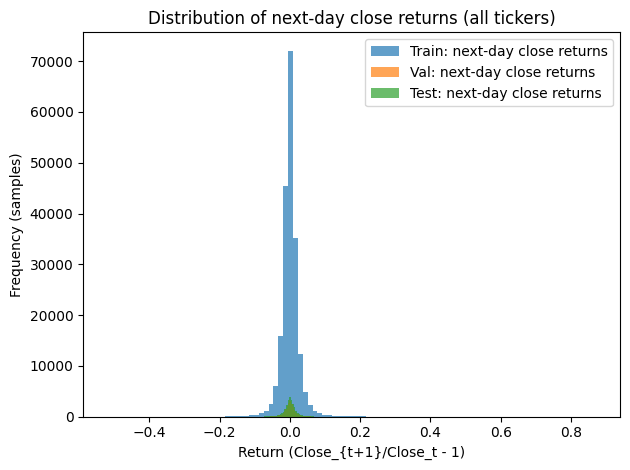

Histogram of next-day close returns for each split. Helps spot fat tails, skew, and whether train/val/test distributions align.



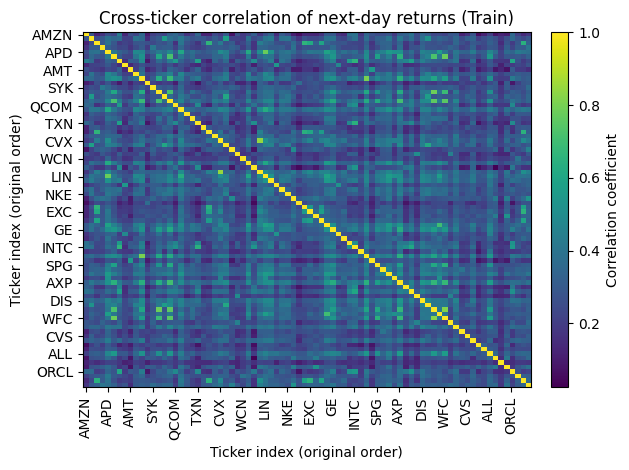

Heatmap of correlations between tickers’ next-day returns on the TRAIN set. Bright = move together; dark = move inversely; near zero = independent.



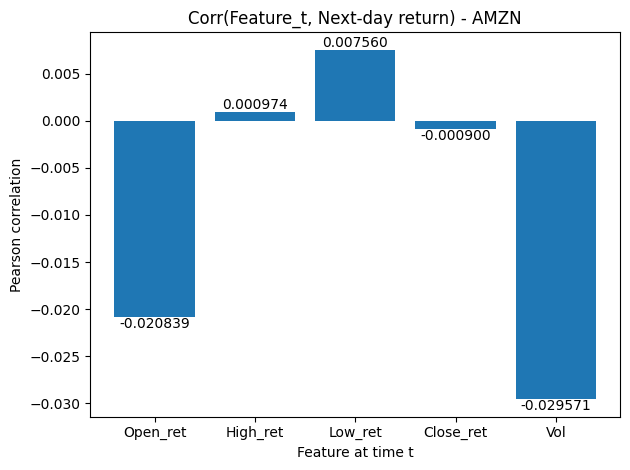

For AMZN, correlation between each feature at day t and the ticker’s next-day return. Shows which inputs tend to move with (or against) the target.



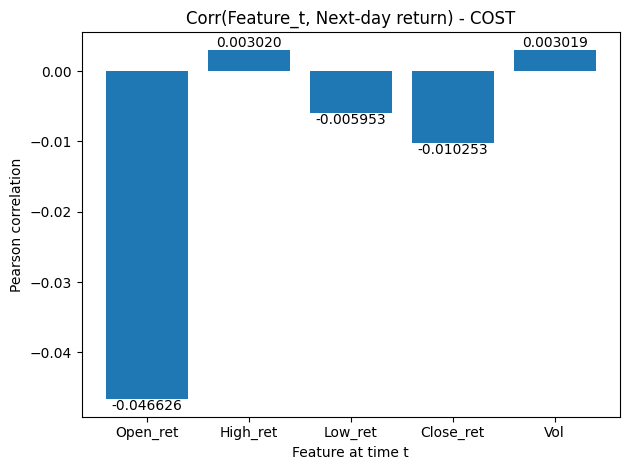

For COST, correlation between each feature at day t and the ticker’s next-day return. Shows which inputs tend to move with (or against) the target.



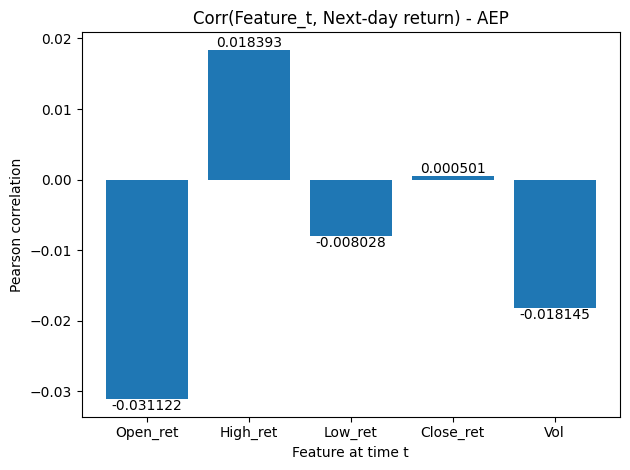

For AEP, correlation between each feature at day t and the ticker’s next-day return. Shows which inputs tend to move with (or against) the target.



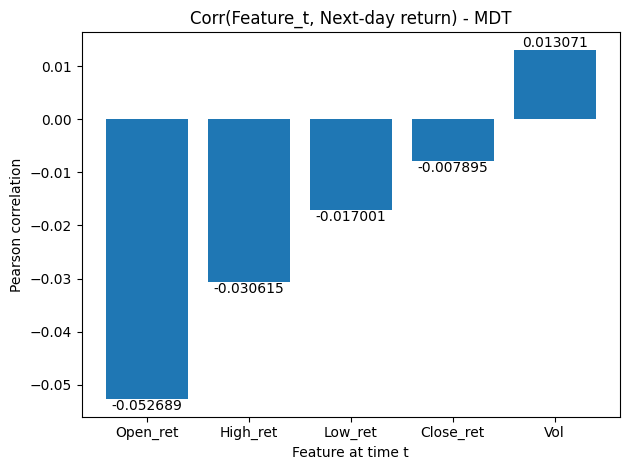

For MDT, correlation between each feature at day t and the ticker’s next-day return. Shows which inputs tend to move with (or against) the target.



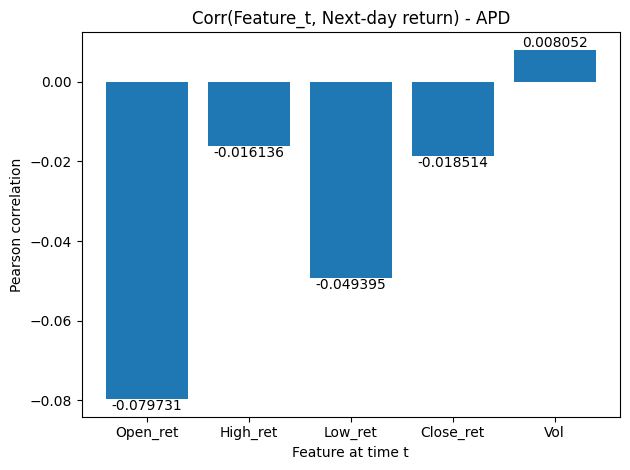

For APD, correlation between each feature at day t and the ticker’s next-day return. Shows which inputs tend to move with (or against) the target.



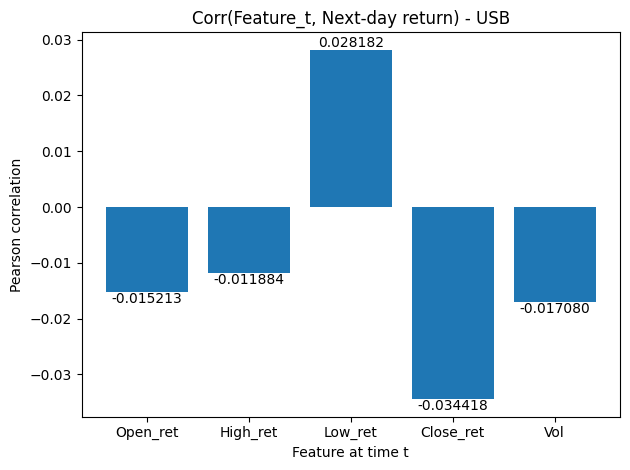

For USB, correlation between each feature at day t and the ticker’s next-day return. Shows which inputs tend to move with (or against) the target.



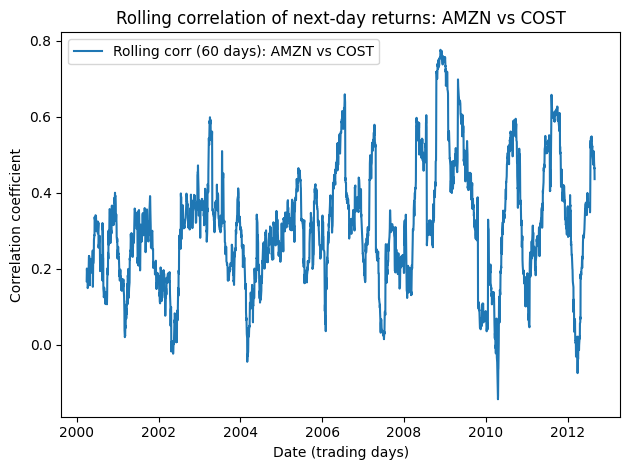

Time-varying correlation of next-day returns between AMZN and COST over a 60-day window. Useful for regime changes.



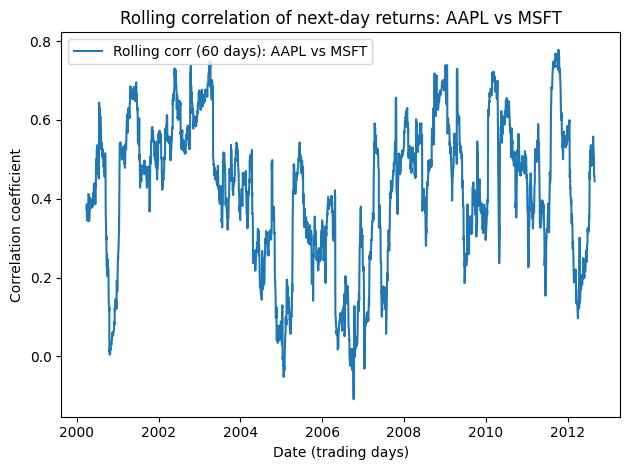

Time-varying correlation of next-day returns between AAPL and MSFT over a 60-day window. Useful for regime changes.



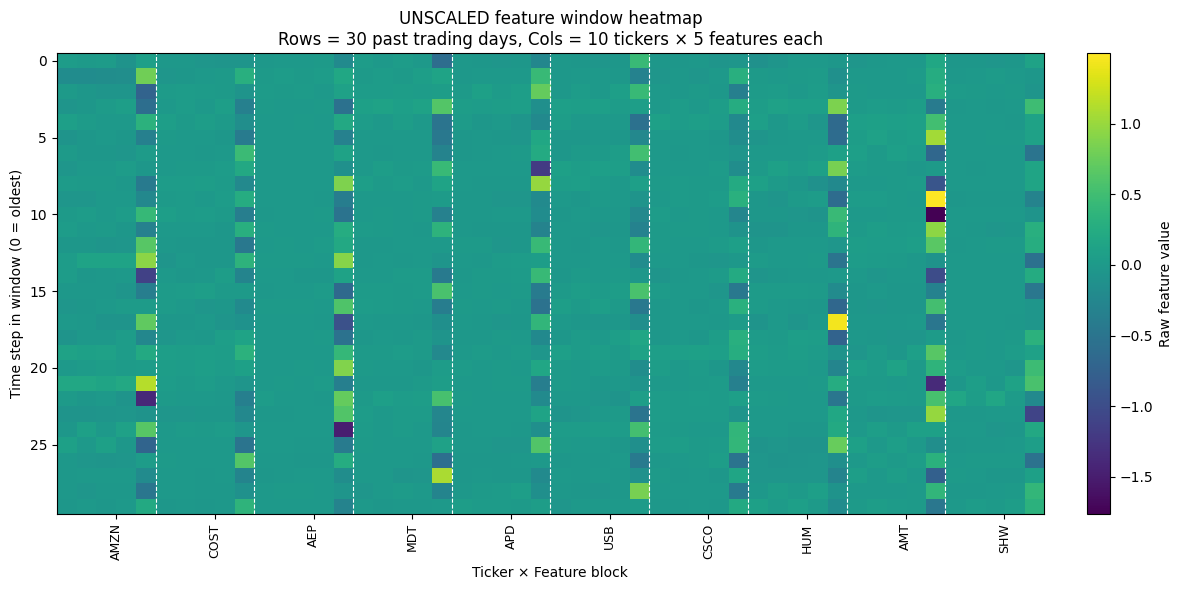

UNSCALED heatmap of a single input window. Raw magnitudes can dominate the color scale; useful to see actual values and outliers before standardization.



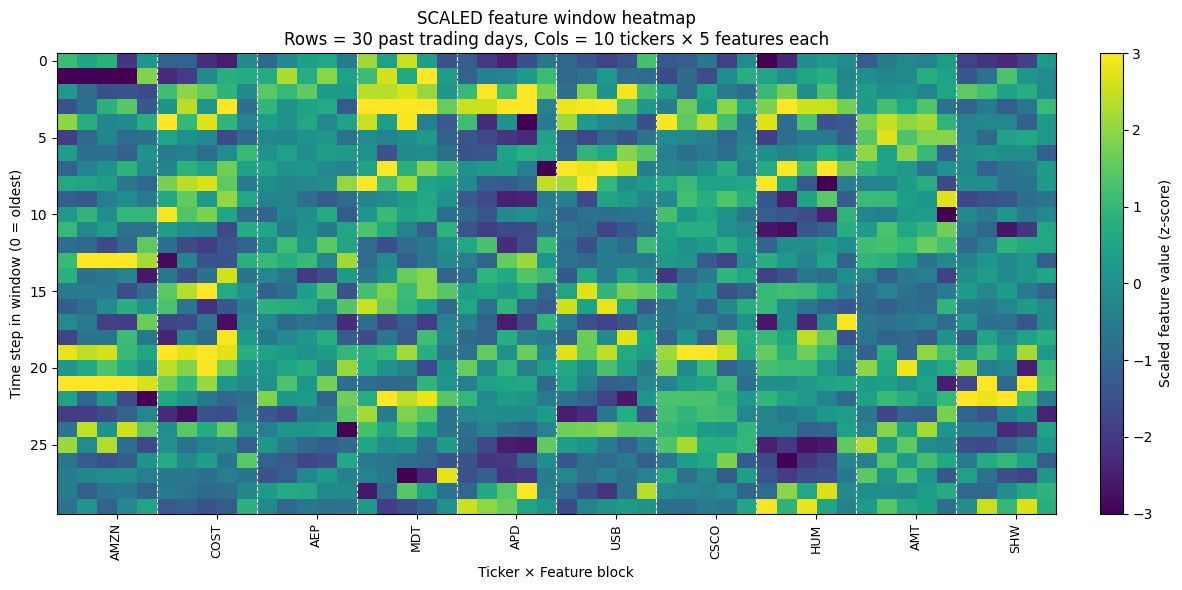

SCALED heatmap of the same window. Colors show deviations from the TRAIN mean (z-scores). Makes patterns comparable across tickers/features.



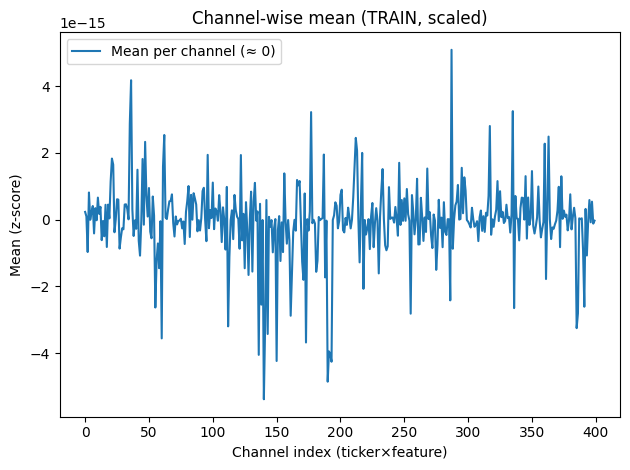

Per-channel mean across the entire TRAIN set after scaling. Most values should sit near 0 if StandardScaler was applied correctly.



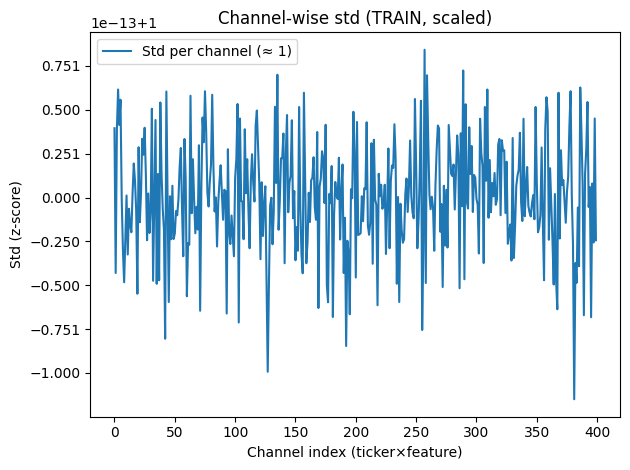

Per-channel standard deviation after scaling. Values should be close to 1; large deviations may indicate unusual variance or many repeats/zeros.



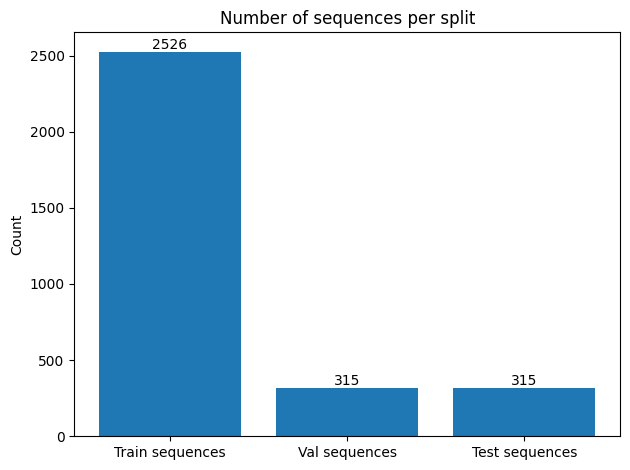

Counts of sequence windows in each split. Sanity check for your chronological splitting.



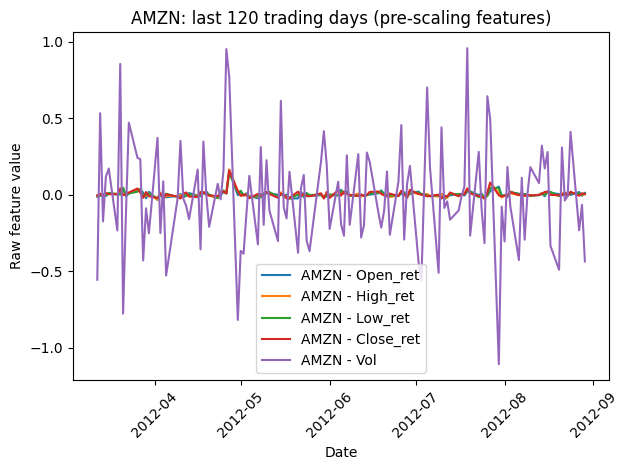

UNSCALED feature lines for AMZN over the last 120 trading days. Shows real magnitudes and any outliers before standardization.



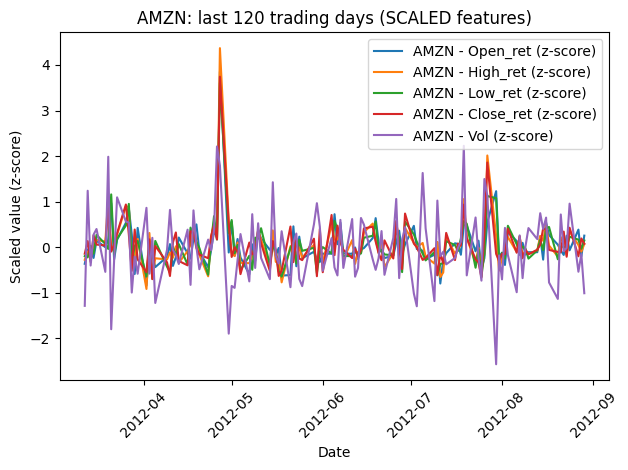

SCALED feature lines for AMZN over the last 120 trading days. Now all features are on a comparable z-score scale (mean≈0, std≈1).



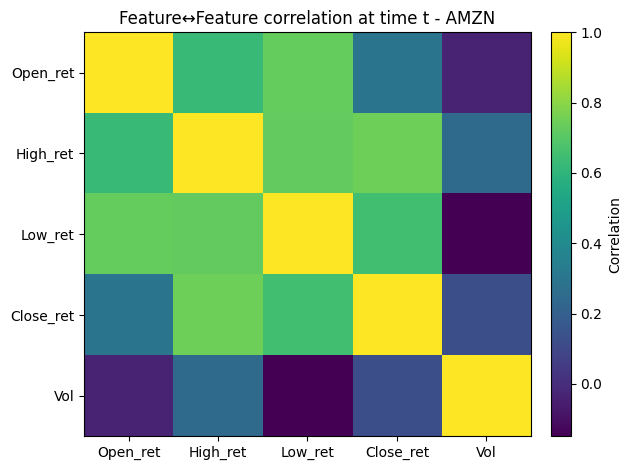

Correlation among AMZN's input features at time t. Helps detect redundant features or unusually strong relationships (e.g., Open/Close nearly identical).



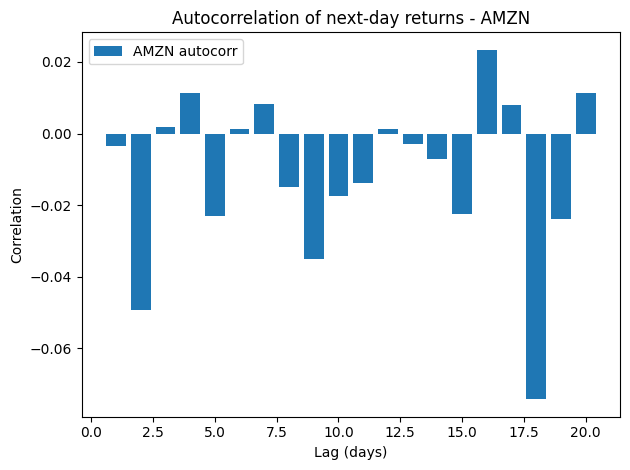

Autocorrelation of AMZN's next-day returns for lags 1..20. Persistent positive bars suggest momentum; negatives suggest mean reversion.



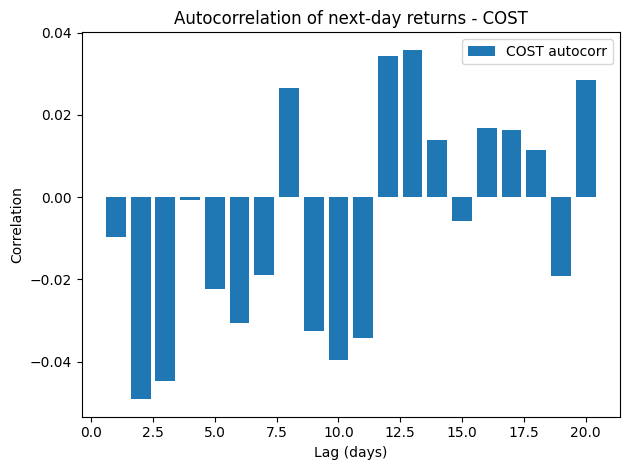

Autocorrelation of COST's next-day returns for lags 1..20. Persistent positive bars suggest momentum; negatives suggest mean reversion.



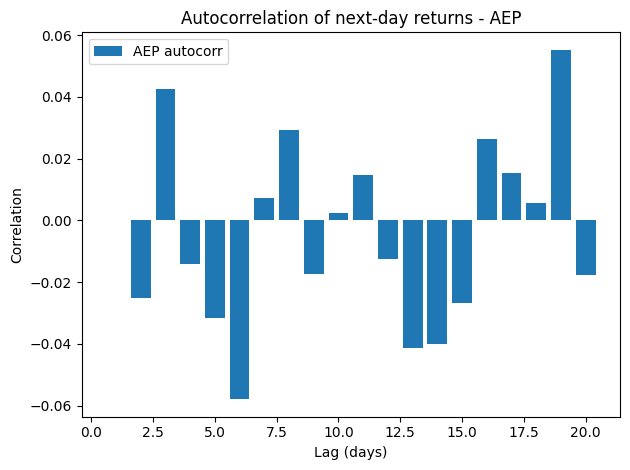

Autocorrelation of AEP's next-day returns for lags 1..20. Persistent positive bars suggest momentum; negatives suggest mean reversion.



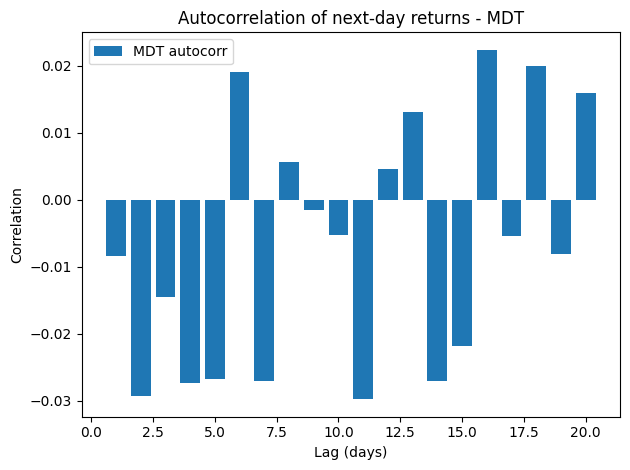

Autocorrelation of MDT's next-day returns for lags 1..20. Persistent positive bars suggest momentum; negatives suggest mean reversion.



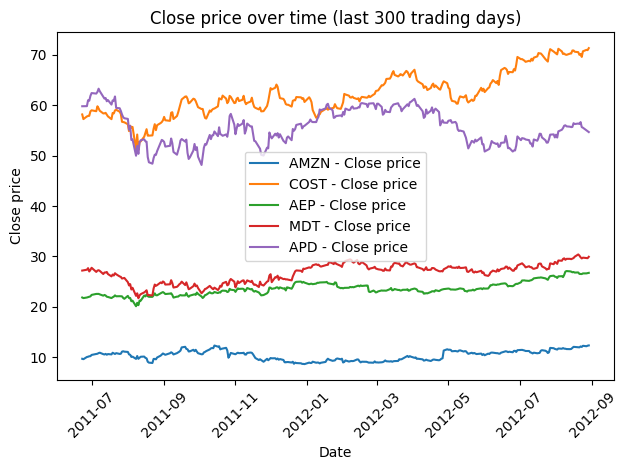

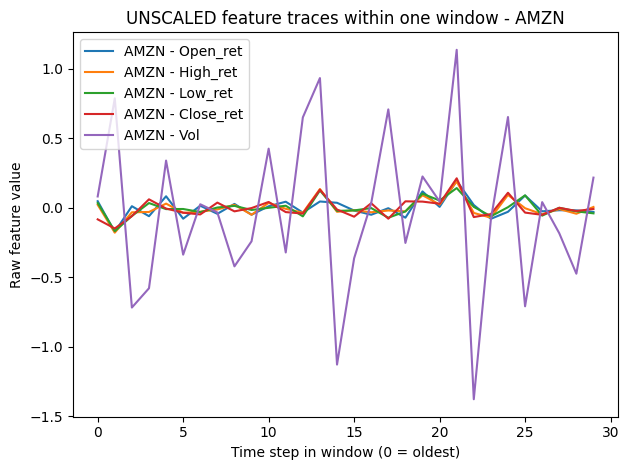

 Unscaled traces: raw magnitudes before standardization. Useful to see outliers and actual units per feature.



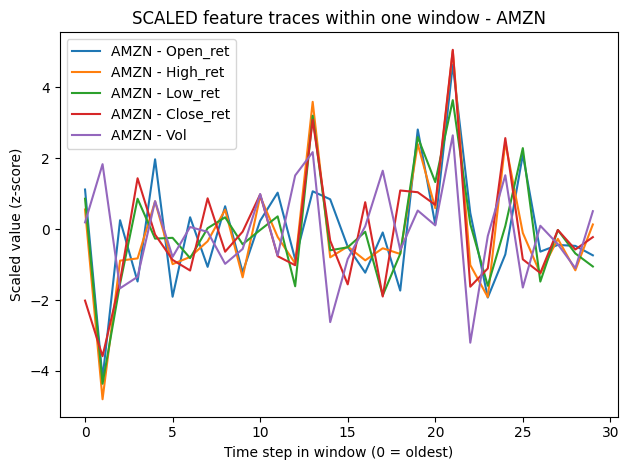

 Scaled traces: z-scores after StandardScaler (fit on TRAIN). Different features are comparable across magnitude.



In [ ]:
# =========================
# RUN ALL
# =========================

# 1) Distributions & correlations (preprocessing-level)
plot_target_distributions(y_train, y_val, y_test)
plot_cross_ticker_corr(y_train, tickers)
plot_per_ticker_feature_target_corr(X_panel, Y_panel, tickers, base_feats, sample_tickers=tickers[:6])
if len(tickers) >= 2:
    plot_rolling_corr(Y_panel, tickers[0], tickers[1], window=60)
    plot_rolling_corr(Y_panel, tickers[57], tickers[58], window=60)

# 2) One input window — UNSCALED then SCALED (same window)
win_scaled = X_train_scaled[0]                   # (SEQ_LEN, channels)
win_unscaled = inverse_window(win_scaled, feature_scaler)
plot_sequence_heatmap_unscaled(win_unscaled, tickers, base_feats, label_first_k_tickers=10)
plot_sequence_heatmap_scaled  (win_scaled,   tickers, base_feats, label_first_k_tickers=10)

# 3) Train-wide scaled stats
plot_channel_stats_scaled(X_train_scaled)
plot_split_sizes(X_train_scaled, X_val_scaled, X_test_scaled)

# 4) Last 120 trading days for first ticker — UNSCALED then SCALED
plot_first_ticker_raw_features_over_time(X_panel, tickers, base_feats, days=120)
plot_first_ticker_scaled_features_over_time(X_panel, tickers, base_feats, feature_scaler, days=120)

# 5) Windows trace
plot_feature_feature_corr_for_ticker(X_panel, ticker=tickers[0], base_feats=base_feats)
plot_autocorr_targets(Y_panel, sample_tickers=tickers[:4], max_lag=20)

# 6) Misc.
plot_close_prices(Close_t_panel, tickers, last_days=300)

# pick a window and a ticker index to inspect
k_window = 0                 # e.g., first training window
ticker_idx = 0               # first ticker in your original order

win_scaled = X_train_scaled[k_window]  # shape: (SEQ_LEN, num_tickers*num_feats)

# Unscaled (raw) traces first, then the scaled version of the same window:
plot_ticker_window_traces_unscaled(win_scaled, ticker_idx, tickers, base_feats, num_feats, feature_scaler)
plot_ticker_window_traces_scaled  (win_scaled, ticker_idx, tickers, base_feats, num_feats)


##**MODEL TRAINING**

In [ ]:
import math, time
from sklearn.linear_model import Ridge
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# =========================
# CONFIG
# =========================
H = 5                     # prediction horizon: next 5 trading days close
SEQ_LEN = SEQ_LEN         # keep your existing window length (e.g., 30)
USE_EXISTING_SPLITS = False
TRAIN_RATIO, VAL_RATIO = 0.8, 0.1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 42
np.random.seed(SEED); torch.manual_seed(SEED)

# Transformer hyperparams (larger than before)
EPOCHS = 80
BATCH_SIZE = 128
LR = 3e-4
D_MODEL = 256
N_HEAD = 8
N_LAYERS = 6
FF_DIM = 512
DROPOUT = 0.1
WEIGHT_DECAY = 1e-5
GRAD_CLIP = 1.0
USE_EARLY_STOPPING = True
PATIENCE = 10

# Ridge & ensemble
USE_RIDGE_ENSEMBLE = True
RIDGE_ALPHA = 1.0
ENSEMBLE_GRID = np.linspace(0.0, 1.0, 21)  # weight on Transformer

In [ ]:
# =========================
# SANITY CHECKS
# =========================
assert isinstance(X_panel, pd.DataFrame) and isinstance(X_panel.columns, pd.MultiIndex), "X_panel must be MultiIndex DataFrame (Ticker, Feature)"
base_feats = ['Open_ret','High_ret','Low_ret','Close_ret','Vol']
for f in base_feats:
    if (tickers[0], f) not in X_panel.columns:
        raise RuntimeError(f"Missing feature '{f}' in X_panel")

# =========================
# FEATURE ENGINEERING
# =========================
def build_enhanced_features(X_panel, tickers, base_feats):
    """
    Inputs:
      X_panel: DataFrame indexed by date, columns MultiIndex (Ticker, Feature) with base_feats
               Close_ret per ticker is daily close return (r_t).
    Adds per-ticker:
      mom_5, mom_10  = rolling sum of Close_ret over 5/10d
      vol_10, vol_20 = rolling std of Close_ret over 10/20d
      z_5            = zscore of Close_ret over 5d
      log_vol        = log(1 + Vol)
      vol_z20        = zscore of Vol over 20d
    Adds MARKET (cross-sectional) factors (broadcast to each ticker):
      mkt_r1         = cross-ticker mean Close_ret (same date)
      mkt_mom_5      = rolling mean of mkt_r1 over 5d
    Returns:
      X_enh: MultiIndex columns with base_feats + new_feats per ticker
    """
    X = X_panel.copy()
    dates = X.index

    # Base: extract needed series
    # Close_ret per ticker
    close_ret = X.loc[:, pd.IndexSlice[:, 'Close_ret']]
    close_ret.columns = [c[0] for c in close_ret.columns]  # flatten to tickers
    # Vol per ticker
    vol_raw = X.loc[:, pd.IndexSlice[:, 'Vol']]
    vol_raw.columns = [c[0] for c in vol_raw.columns]

    # Market cross-sectional factors
    mkt_r1 = close_ret.mean(axis=1)                    # cross-sectional mean return
    mkt_mom_5 = mkt_r1.rolling(5).mean()

    new_blocks = {}
    for tk in tickers:
        r = close_ret[tk]
        v = vol_raw[tk]

        mom_5  = r.rolling(5).sum()
        mom_10 = r.rolling(10).sum()
        vol_10 = r.rolling(10).std()
        vol_20 = r.rolling(20).std()
        z_5    = (r - r.rolling(5).mean()) / (r.rolling(5).std() + 1e-12)

        log_vol = np.log1p(v.clip(lower=0))
        vol_z20 = (v - v.rolling(20).mean()) / (v.rolling(20).std() + 1e-12)

        # Broadcast market factors to this ticker
        blk = pd.DataFrame({
            'Open_ret'  : X[(tk, 'Open_ret')],
            'High_ret'  : X[(tk, 'High_ret')],
            'Low_ret'   : X[(tk, 'Low_ret')],
            'Close_ret' : r,
            'Vol'       : v,
            'mom_5'     : mom_5,
            'mom_10'    : mom_10,
            'vol_10'    : vol_10,
            'vol_20'    : vol_20,
            'z_5'       : z_5,
            'log_vol'   : log_vol,
            'vol_z20'   : vol_z20,
            'mkt_r1'    : mkt_r1,     # same for all tickers on a date
            'mkt_mom_5' : mkt_mom_5
        }, index=dates)
        new_blocks[tk] = blk


    pieces = []
    for tk in tickers:
        df = new_blocks[tk]
        df.columns = pd.MultiIndex.from_product([[tk], df.columns])
        pieces.append(df)
    X_enh = pd.concat(pieces, axis=1).sort_index(axis=1)
    return X_enh

X_enh = build_enhanced_features(X_panel, tickers, base_feats)
enh_feats = list(X_enh.loc[:, tickers[0]].columns)  # all engineered features per ticker
num_feats = len(enh_feats)
num_tickers = len(tickers)


In [ ]:
# =========================
# TARGET: 5-day ahead close (as RETURN)
# =========================
# y_raw[d] = Close_{t+H}/Close_t - 1  aligned with time t as input end
y_all = (Close_t_panel.shift(-H) / Close_t_panel) - 1.0
# we will drop last H rows later to align with features windows

# =========================
# WINDOWING → TENSORS
# =========================
def make_windows(X_enh, y_all, seq_len, tickers):

    #Build (N, L, T*F) feature windows and (N, T) targets.

    X_clean = X_enh.dropna()
    y_clean = y_all.loc[X_clean.index]

    # we need to drop last H rows
    valid_idx = y_clean.index[:-H] if y_clean.iloc[-H:].isna().values.any() else y_clean.index
    X_clean = X_clean.loc[valid_idx]
    y_clean = y_clean.loc[valid_idx]

    dates = X_clean.index
    L = seq_len
    C = len(tickers) * len(enh_feats)

    X_list, y_list, end_dates = [], [], []
    for i in range(L-1, len(dates)):
        end_date = dates[i]
        start = i - (L-1)
        win_X = X_clean.iloc[start:i+1]  # (L, T*F in MultiIndex)
        # flatten columns by (ticker block contiguous)

        cols = []
        for tk in tickers:
            for f in enh_feats:
                cols.append((tk, f))
        win_mat = win_X.loc[:, cols].values  # (L, T*F)
        X_list.append(win_mat)

        y_vec = y_clean.loc[end_date, tickers].values  # (T,)
        y_list.append(y_vec)
        end_dates.append(end_date)

    X_arr = np.array(X_list, dtype=np.float32)        # (N, L, C)
    y_arr = np.array(y_list, dtype=np.float64)        # (N, T)
    end_dates = np.array(end_dates)
    return X_arr, y_arr, end_dates

X_arr, y_arr, end_dates = make_windows(X_enh, y_all, SEQ_LEN, tickers)


In [ ]:
# =========================
# SPLIT (chronological)
# =========================
if USE_EXISTING_SPLITS and all(v in globals() for v in ['dates_train','dates_val','dates_test']):
    # map end_dates to splits
    train_mask = np.isin(end_dates, pd.to_datetime(dates_train))
    val_mask   = np.isin(end_dates, pd.to_datetime(dates_val))
    test_mask  = np.isin(end_dates, pd.to_datetime(dates_test))
else:
    N = len(end_dates)
    n_train = int(N * TRAIN_RATIO)
    n_val   = int(N * VAL_RATIO)
    idx_train = np.arange(0, n_train)
    idx_val   = np.arange(n_train, n_train+n_val)
    idx_test  = np.arange(n_train+n_val, N)
    train_mask = np.zeros(N, dtype=bool); train_mask[idx_train] = True
    val_mask   = np.zeros(N, dtype=bool); val_mask[idx_val] = True
    test_mask  = np.zeros(N, dtype=bool); test_mask[idx_test] = True

X_train, X_val, X_test = X_arr[train_mask], X_arr[val_mask], X_arr[test_mask]
y_train, y_val, y_test = y_arr[train_mask], y_arr[val_mask], y_arr[test_mask]
dates_train, dates_val, dates_test = end_dates[train_mask], end_dates[val_mask], end_dates[test_mask]


In [ ]:
# =========================
# SCALE FEATURES (fit on TRAIN only)
# =========================
# Flatten windows along samples & time to fit scalers channel-wise
C = X_train.shape[-1]
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, C)).reshape(X_train.shape)
X_val_scaled   = scaler_X.transform(X_val.reshape(-1, C)).reshape(X_val.shape)
X_test_scaled  = scaler_X.transform(X_test.reshape(-1, C)).reshape(X_test.shape)


In [ ]:
# =========================
# TARGET STANDARDIZATION
# =========================
target_scalers = {}
y_train_std = np.zeros_like(y_train, dtype=np.float32)
y_val_std   = np.zeros_like(y_val,   dtype=np.float32)
y_test_std  = np.zeros_like(y_test,  dtype=np.float32)
for j, tk in enumerate(tickers):
    sc = StandardScaler()
    y_train_std[:, j] = sc.fit_transform(y_train[:, [j]]).reshape(-1)
    y_val_std[:, j]   = sc.transform(y_val[:, [j]]).reshape(-1)
    y_test_std[:, j]  = sc.transform(y_test[:, [j]]).reshape(-1)
    target_scalers[tk] = sc

def inverse_returns(std_returns: np.ndarray) -> np.ndarray:
    out = np.zeros_like(std_returns, dtype=np.float64)
    for j, tk in enumerate(tickers):
        out[:, j] = target_scalers[tk].inverse_transform(std_returns[:, [j]]).reshape(-1)
    return out


In [ ]:
# =========================
# LAST CLOSE MATRIX (per window end) to convert returns -> PRICES
# =========================
last_close_train = Close_t_panel.loc[pd.to_datetime(dates_train), tickers].values.astype(np.float64)
last_close_val   = Close_t_panel.loc[pd.to_datetime(dates_val),   tickers].values.astype(np.float64)
last_close_test  = Close_t_panel.loc[pd.to_datetime(dates_test),  tickers].values.astype(np.float64)


In [ ]:
# =========================
# TORCH DATASETS
# =========================
class SeqDataset(Dataset):
    def __init__(self, X, y_std, last_close):
        self.X = X.astype(np.float32)
        self.y_std = y_std.astype(np.float32)
        self.last_close = last_close.astype(np.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y_std[i], self.last_close[i]

train_ds = SeqDataset(X_train_scaled, y_train_std, last_close_train)
val_ds   = SeqDataset(X_val_scaled,   y_val_std,   last_close_val)
test_ds  = SeqDataset(X_test_scaled,  y_test_std,  last_close_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
# =========================
# MODEL: Transformer (mean pooling)
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class MarketTransformer(nn.Module):
    def __init__(self, channels, seq_len, num_tickers, d_model=256, nhead=8, num_layers=6, dim_ff=512, dropout=0.1, pool='mean'):
        super().__init__()
        self.pool = pool
        self.inp = nn.Linear(channels, d_model)
        self.pos = PositionalEncoding(d_model, seq_len)
        layer = nn.TransformerEncoderLayer(d_model, nhead, dim_ff, dropout,
                                           batch_first=True, norm_first=True)
        self.enc = nn.TransformerEncoder(layer, num_layers)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_tickers))
    def forward(self, x):  # x: (B,L,C)
        h = self.inp(x)
        h = self.pos(h)
        h = self.enc(h)
        h = h.mean(dim=1) if self.pool == 'mean' else h[:, -1, :]
        return self.head(h)  # standardized returns

C = X_train_scaled.shape[-1]
num_tickers = len(tickers)
model = MarketTransformer(C, SEQ_LEN, num_tickers, d_model=D_MODEL, nhead=N_HEAD,
                          num_layers=N_LAYERS, dim_ff=FF_DIM, dropout=DROPOUT, pool='mean').to(DEVICE)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
# =========================
# TRAIN
# =========================
best_val = float('inf'); best_state=None; pat=0
for epoch in range(1, EPOCHS+1):
    model.train(); t0=time.time(); run=0.0
    for Xb, yb, _ in train_dl:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        yhat = model(Xb)
        loss = criterion(yhat, yb)
        loss.backward()
        if GRAD_CLIP:
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        run += loss.item()*Xb.size(0)
    train_loss = run/len(train_ds)

    # val
    model.eval(); vrun=0.0
    with torch.no_grad():
        for Xb, yb, _ in val_dl:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            yhat = model(Xb)
            vrun += criterion(yhat, yb).item()*Xb.size(0)
    val_loss = vrun/len(val_ds)
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f} | time={time.time()-t0:.1f}s")

    if val_loss < best_val - 1e-6:
        best_val = val_loss; best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}; pat=0
    else:
        pat += 1
        if USE_EARLY_STOPPING and pat >= PATIENCE:
            print("Early stopping."); break
if best_state: model.load_state_dict(best_state)


Epoch 01 | train_loss=0.378017 | val_loss=0.198564 | time=1.8s
Epoch 02 | train_loss=0.361160 | val_loss=0.196406 | time=0.9s
Epoch 03 | train_loss=0.357044 | val_loss=0.196812 | time=0.9s
Epoch 04 | train_loss=0.345633 | val_loss=0.197681 | time=0.9s
Epoch 05 | train_loss=0.326910 | val_loss=0.214408 | time=0.9s
Epoch 06 | train_loss=0.302401 | val_loss=0.224193 | time=0.9s
Epoch 07 | train_loss=0.281555 | val_loss=0.241115 | time=0.9s
Epoch 08 | train_loss=0.264170 | val_loss=0.232423 | time=0.9s
Epoch 09 | train_loss=0.251876 | val_loss=0.249571 | time=0.9s
Epoch 10 | train_loss=0.236551 | val_loss=0.256865 | time=0.9s
Epoch 11 | train_loss=0.224558 | val_loss=0.262077 | time=0.9s
Epoch 12 | train_loss=0.211474 | val_loss=0.262962 | time=0.9s
Early stopping.


In [ ]:
# =========================
# EVALUATION HELPERS
# =========================
def mae(a,b): return float(np.mean(np.abs(a-b)))
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))
def mape(a,b):
    denom=np.clip(np.abs(a),1e-8,None)
    return float(np.mean(np.abs((a-b)/denom)))
def r2(a,b):
    ss_res=np.sum((a-b)**2); ss_tot=np.sum((a-np.mean(a))**2)
    return float(1 - ss_res/(ss_tot+1e-12))

@torch.no_grad()
def eval_get(dl):
    model.eval()
    y_std_true, y_std_pred, lc_list = [], [], []
    for Xb, yb, lcb in dl:
        Xb = Xb.to(DEVICE)
        yhat = model(Xb)
        y_std_true.append(yb.numpy())
        y_std_pred.append(yhat.cpu().numpy())
        lc_list.append(lcb.numpy())
    y_std_true = np.concatenate(y_std_true, axis=0)
    y_std_pred = np.concatenate(y_std_pred, axis=0)
    lc_mat     = np.concatenate(lc_list,     axis=0)
    # inverse-standardize
    y_true = inverse_returns(y_std_true)
    y_pred = inverse_returns(y_std_pred)
    # prices
    pr_true = lc_mat*(1+y_true)
    pr_pred = lc_mat*(1+y_pred)
    return y_true, y_pred, pr_true, pr_pred, lc_mat

def per_ticker_report(y_true, y_pred, pr_true, pr_pred, lc_mat, labels):
    rows=[]
    for j, tk in enumerate(labels):
        rows.append({
            'Ticker': tk,
            'Price_MAE': mae(pr_true[:,j], pr_pred[:,j]),
            'Price_RMSE': rmse(pr_true[:,j], pr_pred[:,j]),
            'Price_MAPE': mape(pr_true[:,j], pr_pred[:,j]),
            'Price_R2': r2(pr_true[:,j], pr_pred[:,j]),
            'Price_R2_base': r2(pr_true[:,j], lc_mat[:,j]),
            'Ret_MAE': mae(y_true[:,j], y_pred[:,j]),
            'Ret_RMSE': rmse(y_true[:,j], y_pred[:,j]),
            'Ret_R2': r2(y_true[:,j], y_pred[:,j]),
            'Ret_R2_base': r2(y_true[:,j], np.zeros_like(y_true[:,j]))
        })
    return pd.DataFrame(rows).set_index('Ticker').sort_index()

def print_macro(df, cols, title):
    print(f"\n{title}")
    print({k: float(df[k].mean()) for k in cols})


##MODEL PREDICTIONS

In [ ]:
# =========================
# 1) Transformer predictions
# =========================
y_tr_t, y_tr_p, pr_tr_t, pr_tr_p, lc_tr = eval_get(train_dl)
y_va_t, y_va_p, pr_va_t, pr_va_p, lc_va = eval_get(val_dl)
y_te_t, y_te_p, pr_te_t, pr_te_p, lc_te = eval_get(test_dl)

df_train_tf = per_ticker_report(y_tr_t, y_tr_p, pr_tr_t, pr_tr_p, lc_tr, tickers)
df_val_tf   = per_ticker_report(y_va_t, y_va_p, pr_va_t, pr_va_p, lc_va, tickers)
df_test_tf  = per_ticker_report(y_te_t, y_te_p, pr_te_t, pr_te_p, lc_te, tickers)

print_macro(df_train_tf, ['Price_MAE','Price_RMSE','Price_MAPE','Price_R2','Ret_MAE','Ret_RMSE','Ret_R2'],
            "TRAIN (Transformer) macro averages")
print_macro(df_val_tf,   ['Price_MAE','Price_RMSE','Price_MAPE','Price_R2','Ret_MAE','Ret_RMSE','Ret_R2'],
            "VAL   (Transformer) macro averages")
print_macro(df_test_tf,  ['Price_MAE','Price_RMSE','Price_MAPE','Price_R2','Ret_MAE','Ret_RMSE','Ret_R2'],
            "TEST  (Transformer) macro averages")



TRAIN (Transformer) macro averages
{'Price_MAE': 0.7907694568749899, 'Price_RMSE': 1.1718944125519335, 'Price_MAPE': 0.03473223789410389, 'Price_R2': 0.9734152984216005, 'Ret_MAE': 0.03445133104827917, 'Ret_RMSE': 0.05019358035528012, 'Ret_R2': 0.012835935868046627}

VAL   (Transformer) macro averages
{'Price_MAE': 0.7341004745470501, 'Price_RMSE': 0.9589990910143167, 'Price_MAPE': 0.02446822387737115, 'Price_R2': 0.8656542372292055, 'Ret_MAE': 0.02442767950968232, 'Ret_RMSE': 0.03178296449427383, 'Ret_R2': -0.017096741671922277}

TEST  (Transformer) macro averages
{'Price_MAE': 0.9240759853081496, 'Price_RMSE': 1.2056243740413541, 'Price_MAPE': 0.02781675189724405, 'Price_R2': 0.8252912519259612, 'Ret_MAE': 0.02766696931856307, 'Ret_RMSE': 0.03647949862066292, 'Ret_R2': -0.011339452853055449}


In [ ]:

# =========================
# 2) Ridge aux model (last-day features per ticker) + ensemble
# =========================
def build_ridge_preds(X_train_scaled, X_val_scaled, X_test_scaled, y_train_raw, y_val_raw, y_test_raw):
    yhat_tr = np.zeros_like(y_train_raw)
    yhat_va = np.zeros_like(y_val_raw)
    yhat_te = np.zeros_like(y_test_raw)
    models=[]
    F = len(enh_feats)
    for j in range(num_tickers):
        s = j*F; e = s+F
        Xtr = X_train_scaled[:, -1, s:e]
        Xva = X_val_scaled[:,   -1, s:e]
        Xte = X_test_scaled[:,  -1, s:e]
        mdl = Ridge(alpha=RIDGE_ALPHA)
        mdl.fit(Xtr, y_train_raw[:, j])
        yhat_tr[:, j] = mdl.predict(Xtr)
        yhat_va[:, j] = mdl.predict(Xva)
        yhat_te[:, j] = mdl.predict(Xte)
        models.append(mdl)
    return models, yhat_tr, yhat_va, yhat_te

if USE_RIDGE_ENSEMBLE:
    models_ridge, y_rg_tr, y_rg_va, y_rg_te = build_ridge_preds(
        X_train_scaled, X_val_scaled, X_test_scaled, y_tr_t, y_va_t, y_te_t
    )

    def choose_weights(y_true_val, y_tf_val, y_rg_val, grid=ENSEMBLE_GRID):
        w = np.zeros(y_true_val.shape[1], dtype=np.float32)
        for j in range(y_true_val.shape[1]):
            yt, yf, yr = y_true_val[:,j], y_tf_val[:,j], y_rg_val[:,j]
            best, bestw = 1e9, 1.0
            for a in grid:
                yhat = a*yf + (1-a)*yr
                e = rmse(yt, yhat)
                if e < best: best, bestw = e, a
            w[j] = bestw
        return w

    w_val = choose_weights(y_va_t, y_va_p, y_rg_va, ENSEMBLE_GRID)

    def blend(y_tf, y_rg, w):
        return y_tf*w[None,:] + y_rg*(1-w[None,:])

    y_tr_ens = blend(y_tr_p, y_rg_tr, w_val)
    y_va_ens = blend(y_va_p, y_rg_va, w_val)
    y_te_ens = blend(y_te_p, y_rg_te, w_val)

    pr_tr_ens = lc_tr*(1+y_tr_ens)
    pr_va_ens = lc_va*(1+y_va_ens)
    pr_te_ens = lc_te*(1+y_te_ens)

    df_train_en = per_ticker_report(y_tr_t, y_tr_ens, pr_tr_t, pr_tr_ens, lc_tr, tickers)
    df_val_en   = per_ticker_report(y_va_t, y_va_ens, pr_va_t, pr_va_ens, lc_va, tickers)
    df_test_en  = per_ticker_report(y_te_t, y_te_ens, pr_te_t, pr_te_ens, lc_te, tickers)

    print_macro(df_train_en, ['Price_MAE','Price_RMSE','Price_MAPE','Price_R2','Ret_MAE','Ret_RMSE','Ret_R2'],
                "TRAIN (Ensemble) macro averages")
    print_macro(df_val_en,   ['Price_MAE','Price_RMSE','Price_MAPE','Price_R2','Ret_MAE','Ret_RMSE','Ret_R2'],
                "VAL   (Ensemble) macro averages")
    print_macro(df_test_en,  ['Price_MAE','Price_RMSE','Price_MAPE','Price_R2','Ret_MAE','Ret_RMSE','Ret_R2'],
                "TEST  (Ensemble) macro averages")

    # print each ticker’s R2
    print("\nPer-ticker Price R2 (TEST, Ensemble):")
    for tk, v in df_test_en['Price_R2'].items():
        print(f"{tk:>6s} : {v:.6f}")



TRAIN (Ensemble) macro averages
{'Price_MAE': 0.7915767463858452, 'Price_RMSE': 1.1717697549939907, 'Price_MAPE': 0.03479070136840203, 'Price_R2': 0.9733689663365851, 'Ret_MAE': 0.03452540974505641, 'Ret_RMSE': 0.05026977652648579, 'Ret_R2': 0.010004280796867375}

VAL   (Ensemble) macro averages
{'Price_MAE': 0.7295031327798935, 'Price_RMSE': 0.9517050688162522, 'Price_MAPE': 0.024334175255117503, 'Price_R2': 0.8674844491514218, 'Ret_MAE': 0.024315745256078086, 'Ret_RMSE': 0.031620022058165595, 'Ret_R2': -0.0070418140399329514}

TEST  (Ensemble) macro averages
{'Price_MAE': 0.9209809583942159, 'Price_RMSE': 1.2013791760094787, 'Price_MAPE': 0.02777122719913151, 'Price_R2': 0.8260498187854666, 'Ret_MAE': 0.027650266814522827, 'Ret_RMSE': 0.0364824708536677, 'Ret_R2': -0.01259798286685529}

Per-ticker Price R2 (TEST, Ensemble):
  AAPL : 0.969058
   ABT : 0.967936
  ADBE : 0.850943
   ADM : 0.713929
   AEP : 0.844186
   ALL : 0.943048
  AMGN : 0.962109
   AMT : 0.940893
  AMZN : 0.686372

In [ ]:
# =========================
# Helpers to print per-ticker R2s
# =========================
def print_per_ticker_r2(df, label):
    print(f"\n--- {label}: per-ticker R2 (Prices) ---")
    for tk, val in df['Price_R2'].items():
        print(f"{tk:>6s} : {val:.6f}")
    print(f"\n--- {label}: per-ticker R2 (Returns) ---")
    for tk, val in df['Ret_R2'].items():
        print(f"{tk:>6s} : {val:.6f}")

print_per_ticker_r2(df_train_tf, "TRAIN (Transformer)")
print_per_ticker_r2(df_val_tf,   "VALIDATION (Transformer)")
print_per_ticker_r2(df_test_tf,  "TEST (Transformer)")

if USE_RIDGE_ENSEMBLE:
    print_per_ticker_r2(df_train_en, "TRAIN (Ensemble TF+Ridge)")
    print_per_ticker_r2(df_val_en,   "VALIDATION (Ensemble TF+Ridge)")
    print_per_ticker_r2(df_test_en,  "TEST (Ensemble TF+Ridge)")



--- TRAIN (Transformer): per-ticker R2 (Prices) ---
  AAPL : 0.993516
   ABT : 0.974568
  ADBE : 0.967629
   ADM : 0.988517
   AEP : 0.973496
   ALL : 0.982814
  AMGN : 0.910946
   AMT : 0.986212
  AMZN : 0.981674
   APD : 0.986754
   AXP : 0.973205
    BA : 0.985439
   BAC : 0.982625
  BIIB : 0.893798
 BRK-B : 0.976515
   BTI : 0.995956
     C : 0.988548
   CAT : 0.988934
   CCI : 0.982663
    CI : 0.979135
 CMCSA : 0.940087
  COST : 0.970631
  CSCO : 0.978135
   CVS : 0.984102
   CVX : 0.989345
    DD : 0.974128
    DE : 0.985544
   DHR : 0.990171
   DIS : 0.963494
   DUK : 0.977355
   ECL : 0.989752
   EXC : 0.991700
     F : 0.986009
    GE : 0.977458
  GILD : 0.993936
    GS : 0.979485
    HD : 0.944680
   HUM : 0.987916
  INTC : 0.968404
   JNJ : 0.974035
   JPM : 0.942077
    KO : 0.955877
    KR : 0.958543
   LIN : 0.992392
   LMT : 0.990661
   MCD : 0.993408
   MDT : 0.918682
   MMM : 0.979316
    MO : 0.994209
   MOS : 0.982520
    MS : 0.955128
  MSFT : 0.906382
   NEE : 0.

In [ ]:
# ====================================
# Directional Accuracy (DA) on returns
# ====================================

TAU = 0.0005

def sign_with_band(x, tau=0.0):
    s = np.zeros_like(x, dtype=np.int8)
    s[x >  tau] = 1
    s[x < -tau] = -1
    return s

def directional_accuracy(y_true, y_pred, tau=0.0):
    S_true = sign_with_band(y_true, tau)
    T = y_true.shape[1]
    acc, cov = np.zeros(T), np.zeros(T)
    for j in range(T):
        mask = S_true[:, j] != 0  # evaluate only when true move is meaningful
        cov[j] = mask.mean() if mask.size else 0.0
        if mask.any():
            acc[j] = (np.sign(y_pred[mask, j]) == S_true[mask, j]).mean()
        else:
            acc[j] = np.nan
    return acc, cov, np.nanmean(acc), np.nanmean(cov)

def get_feature_matrix(X_enh, dates, tickers, feat_name):
    if feat_name != 'mkt_r1':
        return np.column_stack([X_enh.loc[pd.to_datetime(dates), (tk, feat_name)].values
                                for tk in tickers]).astype(np.float64)
    else:
        vec = X_enh.loc[pd.to_datetime(dates), (tickers[0], 'mkt_r1')].values.astype(np.float64)
        return np.tile(vec[:, None], (1, len(tickers)))

def print_da_block(label, y_true, pred_dict, tau=TAU):
    print(f"\n================ Directional Accuracy — {label} (tau={tau}) ================")
    for name, y_pred in pred_dict.items():
        acc, cov, acc_m, cov_m = directional_accuracy(y_true, y_pred, tau)
        print(f"{name:<12s}  DA_macro={acc_m:.3f} | Coverage={cov_m:.3f}")
        # Show 5 worst/best tickers by DA
        order = np.argsort(acc)
        worst = [(tickers[i], acc[i]) for i in order[:5]]
        best  = [(tickers[i], acc[i]) for i in order[::-1][:5]]
        print("  Worst 5: " + ", ".join(f"{tk}:{a:.2f}" for tk,a in worst))
        print("  Best  5: " + ", ".join(f"{tk}:{a:.2f}" for tk,a in best))

# Baselines
mom_train = get_feature_matrix(X_enh, dates_train, tickers, 'Close_ret')
mom_val   = get_feature_matrix(X_enh, dates_val,   tickers, 'Close_ret')
mom_test  = get_feature_matrix(X_enh, dates_test,  tickers, 'Close_ret')

mkt_train = get_feature_matrix(X_enh, dates_train, tickers, 'mkt_r1')
mkt_val   = get_feature_matrix(X_enh, dates_val,   tickers, 'mkt_r1')
mkt_test  = get_feature_matrix(X_enh, dates_test,  tickers, 'mkt_r1')

# Assemble predictions per split (Transformer + optional Ensemble + baselines)
preds_train = {'Transformer': y_tr_p, 'Momentum1d': mom_train, 'Market': mkt_train}
preds_val   = {'Transformer': y_va_p, 'Momentum1d': mom_val,   'Market': mkt_val}
preds_test  = {'Transformer': y_te_p, 'Momentum1d': mom_test,  'Market': mkt_test}
if USE_RIDGE_ENSEMBLE:
    preds_train['Ensemble'] = y_tr_ens
    preds_val['Ensemble']   = y_va_ens
    preds_test['Ensemble']  = y_te_ens

# Print summaries only
print_da_block("TRAIN", y_tr_t, preds_train, tau=TAU)
print_da_block("VAL",   y_va_t, preds_val,   tau=TAU)
print_da_block("TEST",  y_te_t, preds_test,  tau=TAU)



================ Directional Accuracy — TRAIN (tau=0.0005) ================
Transformer   DA_macro=0.546 | Coverage=0.987
  Worst 5: MS:0.49, AMGN:0.51, ABT:0.51, INTC:0.51, AXP:0.52
  Best  5: CI:0.59, HD:0.58, MO:0.58, SAM:0.58, SPG:0.58
Momentum1d    DA_macro=0.496 | Coverage=0.987
  Worst 5: CVS:0.47, CCI:0.47, LMT:0.48, AMT:0.48, PG:0.48
  Best  5: JPM:0.52, AMGN:0.52, KO:0.52, NEE:0.52, MMM:0.51
Market        DA_macro=0.502 | Coverage=0.987
  Worst 5: GS:0.48, CMCSA:0.48, MS:0.48, CVS:0.48, APD:0.49
  Best  5: DE:0.52, CVX:0.52, SO:0.52, AEP:0.52, SRE:0.52
Ensemble      DA_macro=0.545 | Coverage=0.987
  Worst 5: MS:0.49, INTC:0.51, ABT:0.51, CSCO:0.51, MDT:0.52
  Best  5: CI:0.59, HD:0.58, AAPL:0.58, MO:0.58, SPG:0.57

================ Directional Accuracy — VAL (tau=0.0005) ================
Transformer   DA_macro=0.559 | Coverage=0.986
  Worst 5: DD:0.41, INTC:0.45, BRK-B:0.46, AMT:0.46, BAC:0.46
  Best  5: MO:0.69, CVX:0.66, XOM:0.65, CAT:0.65, SPG:0.63
Momentum1d    DA_macro=

In [ ]:
from scipy.stats import pearsonr

# -------------------------------
# HELPER METRICS
# -------------------------------

def smape(y_true, y_pred):
    #Symmetric Mean Absolute Percentage Error (in 0–1 range).
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_pred - y_true)
    return np.nanmean(np.divide(diff, denom + 1e-8))

def mase_price(y_true, y_pred, y_base):
    #Mean Absolute Scaled Error for prices vs persistence baseline.
    num = np.mean(np.abs(y_pred - y_true))
    denom = np.mean(np.abs(y_base[1:] - y_base[:-1]))
    return np.inf if denom < 1e-8 else num / denom

def mase_return(y_true, y_pred):
    #MASE for returns vs zero baseline.
    num = np.mean(np.abs(y_pred - y_true))
    denom = np.mean(np.abs(y_true))
    return np.inf if denom < 1e-8 else num / denom

def theils_u2_price(y_true, y_pred, y_base):
    #Theil's U2 statistic for prices vs persistence baseline (<1 = better).
    num = np.sqrt(np.mean(((y_pred - y_true) / (y_true + 1e-8))**2))
    den = np.sqrt(np.mean(((y_base[1:] - y_true[1:]) / (y_true[1:] + 1e-8))**2))
    return np.inf if den < 1e-8 else num / den

def theils_u2_return(y_true, y_pred):
    #Theil's U2 for returns vs zero baseline (<1 = better).
    num = np.sqrt(np.mean((y_pred - y_true)**2))
    den = np.sqrt(np.mean((y_true)**2))
    return np.inf if den < 1e-8 else num / den

def pearson_corr(y_true, y_pred):
    #Pearson correlation (ρ).
    if np.std(y_true) < 1e-8 or np.std(y_pred) < 1e-8:
        return np.nan
    return pearsonr(y_true, y_pred)[0]

# -------------------------------
# DIRECTIONAL ACCURACY METRICS
# -------------------------------

DA_TAU = 0.0  # threshold for classifying up/down (you can set 0.001 if needed)

def directional_classification_metrics(y_true, y_pred, tau=0.0):
    '''
      Computes directional accuracy metrics:
        - Accuracy: fraction of correct UP/DOWN directions
        - Precision/Recall/F1 for UP moves
    '''
    # Binary: 1 = up (>tau), 0 = down (<-tau)
    up_true = (y_true > tau).astype(int)
    up_pred = (y_pred > tau).astype(int)

    acc = np.mean(up_true == up_pred)
    tp = np.sum((up_true == 1) & (up_pred == 1))
    fp = np.sum((up_true == 0) & (up_pred == 1))
    fn = np.sum((up_true == 1) & (up_pred == 0))

    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)

    return {
        "Accuracy": float(acc),
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1)
    }


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, precision_score, recall_score
# ---------- per-split suite ----------
def evaluation_suite(label, y_true, y_pred, pr_true, pr_pred, lc_mat):
    """
    Prints macro metrics across tickers for:
      - Prices: sMAPE, MASE, Theil's U2, Pearson corr, Bias, Median Error
      - Returns: sMAPE, MASE, Theil's U2, Pearson corr, Bias, Median Error
      - Directional classification metrics (UP vs DOWN)
    """
    # aggregate across tickers by averaging per-ticker metrics
    price_smapes, price_mases, price_u2s, price_rhos, price_bias, price_med = [], [], [], [], [], []
    ret_smapes,   ret_mases,   ret_u2s,   ret_rhos,   ret_bias,   ret_med   = [], [], [], [], [], []

    for j in range(y_true.shape[1]):
        # per-ticker slices
        pr_t = pr_true[:, j]; pr_p = pr_pred[:, j]; pr_b = lc_mat[:, j]  # persistence baseline
        rt_t = y_true[:, j];  rt_p = y_pred[:, j]

        price_smapes.append(smape(pr_t, pr_p))
        price_mases.append(mase_price(pr_t, pr_p, pr_b))
        price_u2s.append(theils_u2_price(pr_t, pr_p, pr_b))
        price_rhos.append(pearson_corr(pr_t, pr_p))
        price_bias.append(float(np.mean(pr_p - pr_t)))
        price_med.append(float(np.median(pr_p - pr_t)))

        ret_smapes.append(smape(rt_t, rt_p))
        ret_mases.append(mase_return(rt_t, rt_p))
        ret_u2s.append(theils_u2_return(rt_t, rt_p))
        ret_rhos.append(pearson_corr(rt_t, rt_p))
        ret_bias.append(float(np.mean(rt_p - rt_t)))
        ret_med.append(float(np.median(rt_p - rt_t)))

    print(f"\n==================== {label} — EXTRA METRICS ====================")
    print("Prices:")
    print({
        'sMAPE': float(np.nanmean(price_smapes)),
        'MASE' : float(np.nanmean(price_mases)),     # <1.0 beats persistence
        'TheilU2': float(np.nanmean(price_u2s)),     # <1.0 beats persistence
        'Corr': float(np.nanmean(price_rhos)),
        'Bias(mean err)': float(np.nanmean(price_bias)),
        'Median err': float(np.nanmean(price_med)),
    })
    print("Returns:")
    print({
        'sMAPE': float(np.nanmean(ret_smapes)),
        'MASE' : float(np.nanmean(ret_mases)),       # <1.0 beats zero-return
        'TheilU2': float(np.nanmean(ret_u2s)),       # <1.0 beats zero-return
        'Corr': float(np.nanmean(ret_rhos)),
        'Bias(mean err)': float(np.nanmean(ret_bias)),
        'Median err': float(np.nanmean(ret_med)),
    })

    # Directional classification metrics
    cls = directional_classification_metrics(y_true, y_pred, tau=DA_TAU)
    print("Direction (returns):", cls)


In [ ]:
# ---------- call for Transformer ----------
evaluation_suite("TRAIN (Transformer)",
                 y_tr_t, y_tr_p, pr_tr_t, pr_tr_p, lc_tr)
evaluation_suite("VAL (Transformer)",
                 y_va_t, y_va_p, pr_va_t, pr_va_p, lc_va)
evaluation_suite("TEST (Transformer)",
                 y_te_t, y_te_p, pr_te_t, pr_te_p, lc_te)


==================== TRAIN (Transformer) — EXTRA METRICS ====================
Prices:
{'sMAPE': 0.03440962785851194, 'MASE': 0.09178419439047773, 'TheilU2': 0.9978533487523638, 'Corr': 0.9868360361414169, 'Bias(mean err)': 0.06722624681720608, 'Median err': 0.03105112128211617}
Returns:
{'sMAPE': 1.6389438065927606, 'MASE': 0.9902342647272082, 'TheilU2': 0.991352447468928, 'Corr': 0.16029655004472032, 'Bias(mean err)': 0.0008614840193125171, 'Median err': 0.0012649992928980014}
Direction (returns): {'Accuracy': 0.5448552894211577, 'Precision': 0.5439242351219366, 'Recall': 0.8808820763587661, 'F1': 0.6725589329476518}

==================== VAL (Transformer) — EXTRA METRICS ====================
Prices:
{'sMAPE': 0.024373118492690252, 'MASE': 2.2684702954573224, 'TheilU2': 1.0043011333512737, 'Corr': 0.9339275220299301, 'Bias(mean err)': 0.04087591966567476, 'Median err': 0.006670427793573988}
Returns:
{'sMAPE': 1.5867051232146723, 'MASE': 0.9914562380957523, 'TheilU2': 0.99671604497078

In [ ]:
# ---------- call for Ensemble (if enabled) ----------
if USE_RIDGE_ENSEMBLE:
    evaluation_suite("TRAIN (Ensemble TF+Ridge)",
                     y_tr_t, y_tr_ens, pr_tr_t, pr_tr_ens, lc_tr)
    evaluation_suite("VAL (Ensemble TF+Ridge)",
                     y_va_t, y_va_ens, pr_va_t, pr_va_ens, lc_va)
    evaluation_suite("TEST (Ensemble TF+Ridge)",
                     y_te_t, y_te_ens, pr_te_t, pr_te_ens, lc_te)



==================== TRAIN (Ensemble TF+Ridge) — EXTRA METRICS ====================
Prices:
{'sMAPE': 0.034483336969104335, 'MASE': 0.09192181405078344, 'TheilU2': 0.998368103775775, 'Corr': 0.9867751581726294, 'Bias(mean err)': 0.04760156537208817, 'Median err': 0.010980151797936289}
Returns:
{'sMAPE': 1.666072281721317, 'MASE': 0.9921729841417033, 'TheilU2': 0.9927763364882942, 'Corr': 0.12685911766334418, 'Bias(mean err)': 0.00033073643129845863, 'Median err': 0.0006814901267700932}
Direction (returns): {'Accuracy': 0.5439870259481038, 'Precision': 0.5439984936657147, 'Recall': 0.8694000376151148, 'F1': 0.6692412607514738}

==================== VAL (Ensemble TF+Ridge) — EXTRA METRICS ====================
Prices:
{'sMAPE': 0.02426189017629835, 'MASE': 2.2575203471707597, 'TheilU2': 0.9980092313178514, 'Corr': 0.9341849539738375, 'Bias(mean err)': 0.006120488391247661, 'Median err': -0.027522828655855903}
Returns:
{'sMAPE': 1.6098862924944446, 'MASE': 0.9869311413760127, 'TheilU2': 0

## POST-TEST PLOTTING & ANALYSIS


In [ ]:
# ---------- Choose which predictions to visualize ----------
if 'USE_RIDGE_ENSEMBLE' in globals() and USE_RIDGE_ENSEMBLE:
    y_pred_use  = y_te_ens
    pr_pred_use = pr_te_ens
    df_use      = df_test_en
    model_label = "Ensemble (TF+Ridge)"
else:
    y_pred_use  = y_te_p
    pr_pred_use = pr_te_p
    df_use      = df_test_tf
    model_label = "Transformer"

dates_test_idx = pd.to_datetime(dates_test)


In [ ]:
# ---------- Small helpers ----------
def r2(a,b):
    ss_res = np.sum((a-b)**2)
    ss_tot = np.sum((a-np.mean(a))**2)
    return float(1 - ss_res/(ss_tot+1e-12))
def pearson(a,b):
    if np.std(a)<1e-12 or np.std(b)<1e-12: return np.nan
    return float(np.corrcoef(a,b)[0,1])

def pick_tickers_by(df_col, top_k=4, bottom_k=4):
    top = df_use[df_col].sort_values(ascending=False).head(top_k).index.tolist()
    bot = df_use[df_col].sort_values(ascending=True).head(bottom_k).index.tolist()
    return top, bot

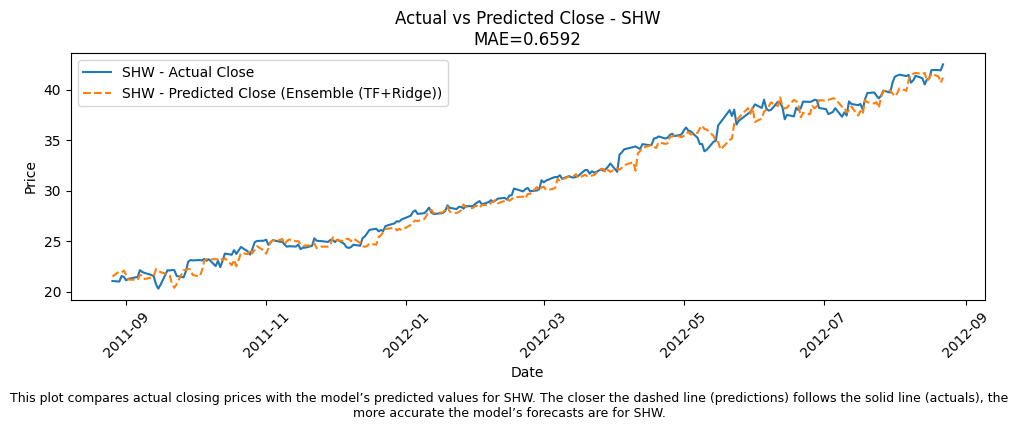

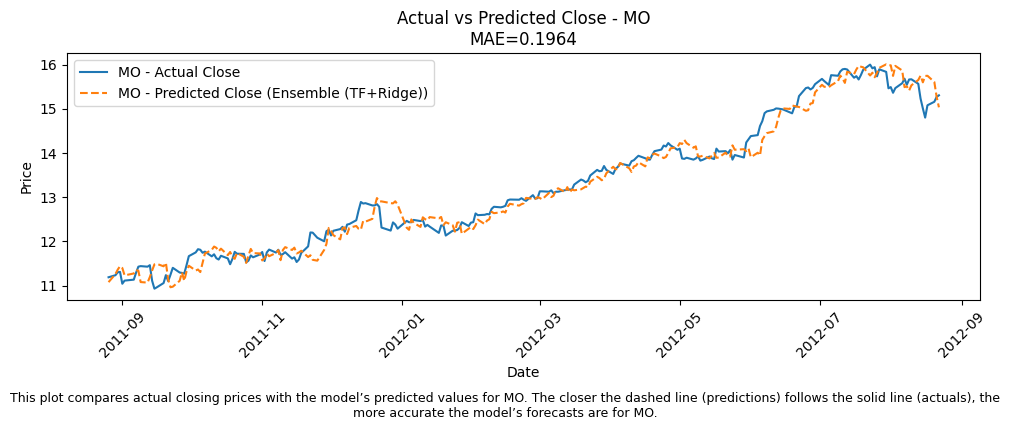

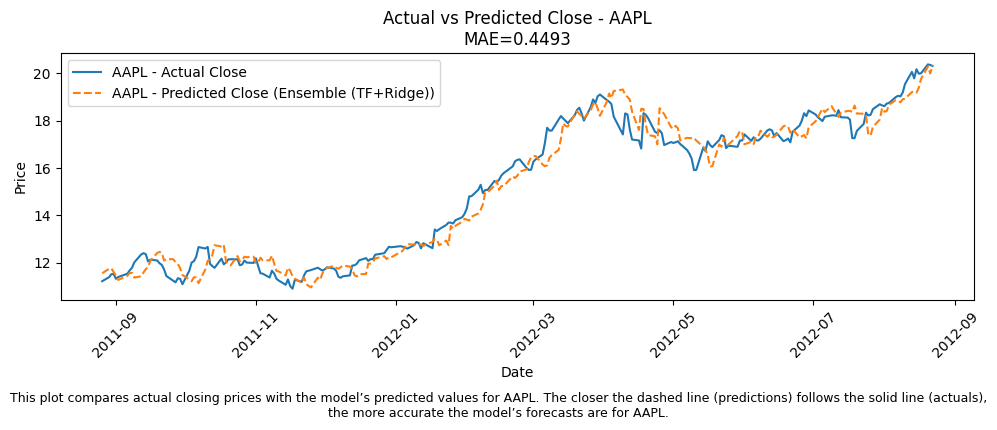

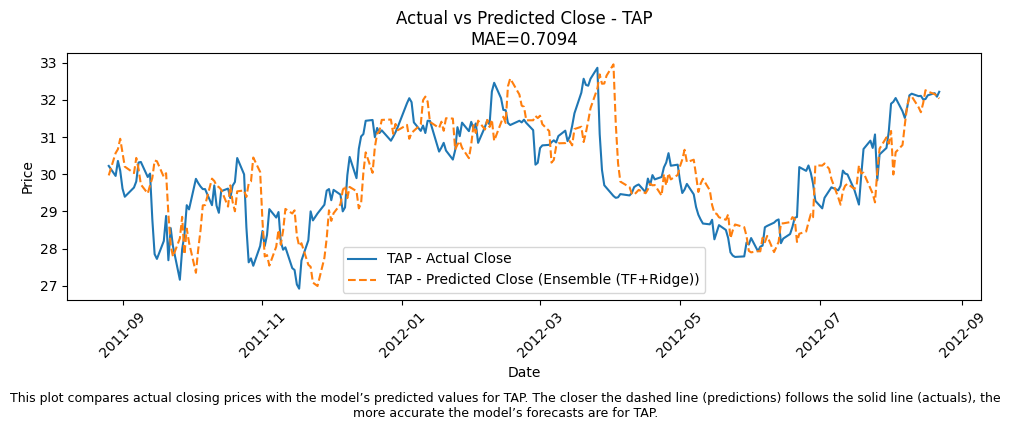

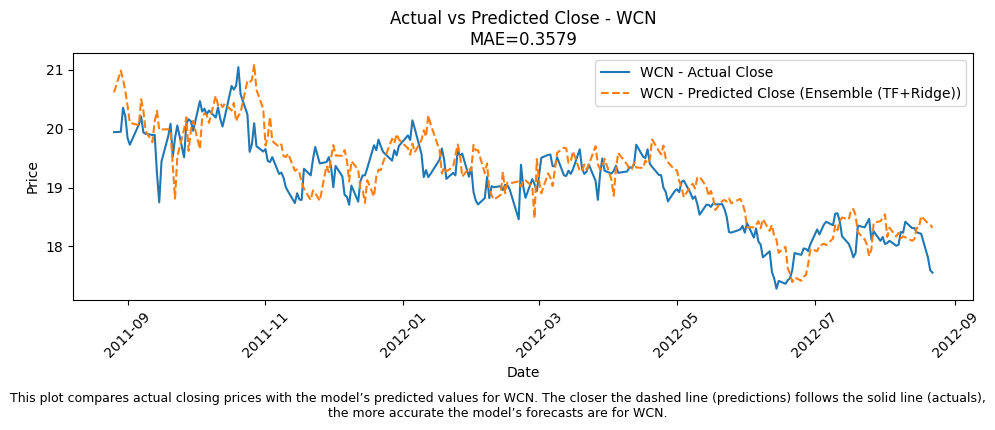

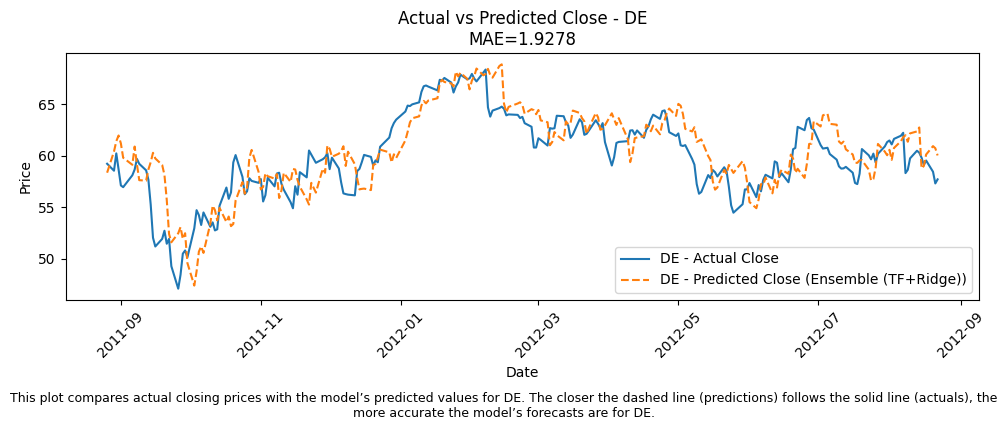

In [ ]:
def plot_price_series(ticker_list, last_n=250):
    for tk in ticker_list:
        j = list(tickers).index(tk)
        true = pr_te_t[:, j]
        pred = pr_pred_use[:, j]
        if len(true) > last_n:
            true = true[-last_n:]
            pred = pred[-last_n:]
            dts = dates_test_idx[-last_n:]
        else:
            dts = dates_test_idx
        plt.figure(figsize=(10,4))
        plt.plot(dts, true, label=f'{tk} - Actual Close')
        plt.plot(dts, pred, label=f'{tk} - Predicted Close ({model_label})', linestyle='--')
        e = np.mean(np.abs(pred - true))
        plt.title(f'Actual vs Predicted Close - {tk}\nMAE={e:.4f}')
        plt.xlabel('Date'); plt.ylabel('Price'); plt.legend(); plt.xticks(rotation=45); plt.tight_layout()
        plt.figtext(0.5, -0.05,
                    f'This plot compares actual closing prices with the model’s predicted values for {tk}. '
                    f'The closer the dashed line (predictions) follows the solid line (actuals), '
                    f'the more accurate the model’s forecasts are for {tk}.',
                    wrap=True, ha='center', fontsize=9)
        plt.show()

top3, bot3 = pick_tickers_by('Price_R2', top_k=3, bottom_k=3)
plot_price_series(top3 + bot3, last_n=250)

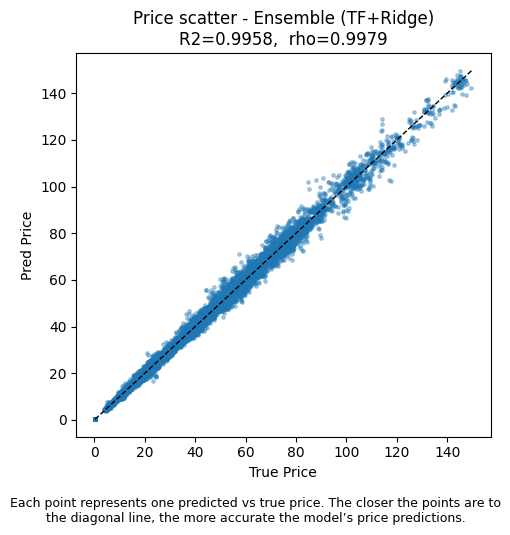

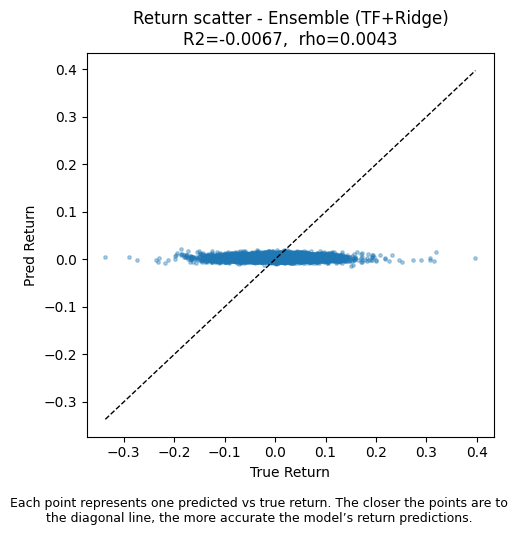

In [ ]:

# ========== 2) Scatter: True vs Predicted (prices & returns) ==========
def plot_scatter_true_pred(title, y_true, y_pred, unit=''):
    a = y_true.reshape(-1); b = y_pred.reshape(-1)
    R2 = r2(a,b); R = pearson(a,b)
    lims = [min(a.min(), b.min()), max(a.max(), b.max())]
    plt.figure(figsize=(5,5))
    plt.scatter(a, b, s=6, alpha=0.35)
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlabel(f'True {unit}'); plt.ylabel(f'Pred {unit}')
    plt.title(f'{title}\nR2={R2:.4f},  rho={R:.4f}')
    plt.tight_layout()
    plt.figtext(0.5, -0.05,
                f'Each point represents one predicted vs true {unit.lower()}. '
                f'The closer the points are to the diagonal line, the more accurate the model’s {unit.lower()} predictions.',
                wrap=True, ha='center', fontsize=9)
    plt.show()

plot_scatter_true_pred(f'Price scatter - {model_label}', pr_te_t, pr_pred_use, unit='Price')
plot_scatter_true_pred(f'Return scatter - {model_label}', y_te_t, y_pred_use, unit='Return')


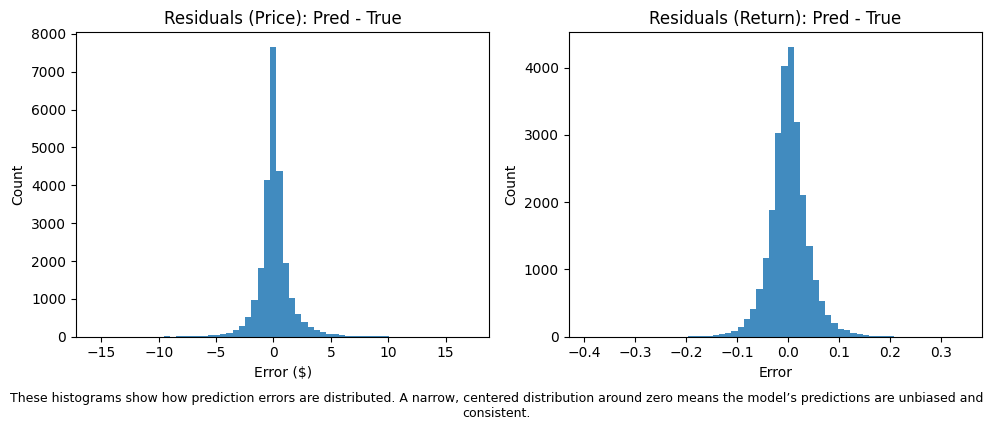

In [ ]:
# ========== 3) Residual histograms (price & return) ==========
def plot_residual_histograms():
    pr_res = (pr_pred_use - pr_te_t).reshape(-1)
    rt_res = (y_pred_use - y_te_t).reshape(-1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(pr_res, bins=60, alpha=0.85)
    plt.title('Residuals (Price): Pred - True')
    plt.xlabel('Error ($)'); plt.ylabel('Count')
    plt.subplot(1,2,2)
    plt.hist(rt_res, bins=60, alpha=0.85)
    plt.title('Residuals (Return): Pred - True')
    plt.xlabel('Error'); plt.ylabel('Count')
    plt.tight_layout()
    plt.figtext(0.5, -0.05,
                'These histograms show how prediction errors are distributed. '
                'A narrow, centered distribution around zero means the model’s predictions are unbiased and consistent.',
                wrap=True, ha='center', fontsize=9)
    plt.show()
plot_residual_histograms()

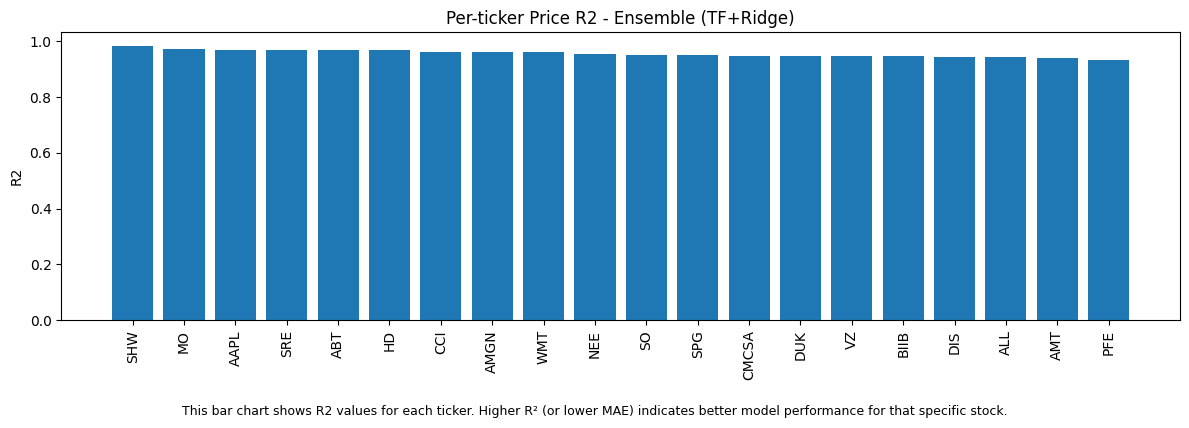

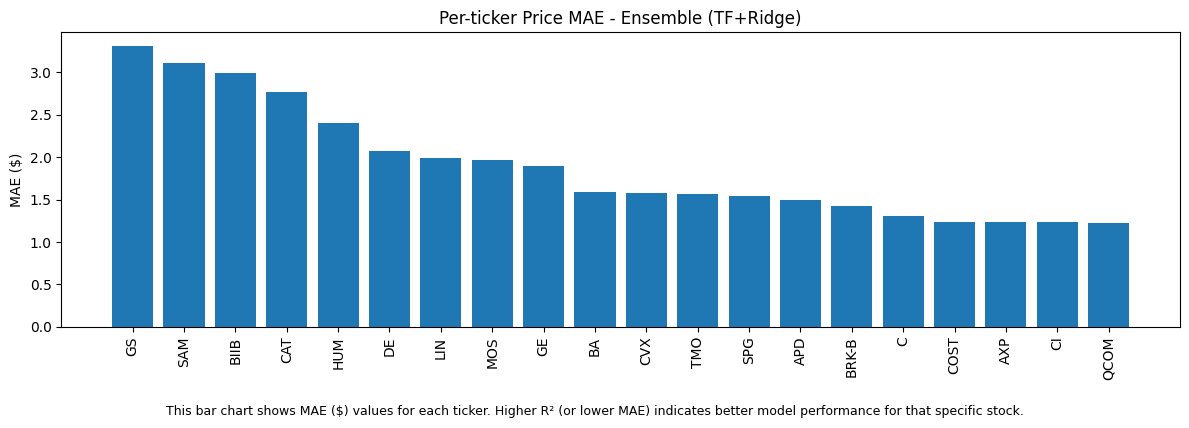

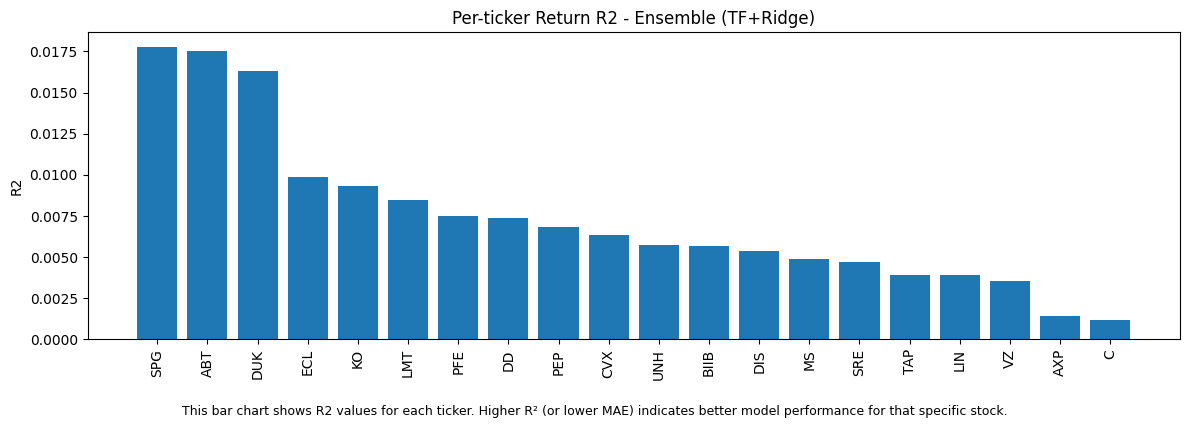

In [ ]:

# ========== 4) Per-ticker bars: R2 & MAE ==========
def bar_metric(df, col, title, ylabel, top_n=20):
    s = df[col].sort_values(ascending=False)
    if len(s) > top_n:
        s = s.head(top_n)
    plt.figure(figsize=(12,4))
    plt.bar(s.index, s.values)
    plt.title(title); plt.ylabel(ylabel)
    plt.xticks(rotation=90); plt.tight_layout()
    plt.figtext(0.5, -0.05,
                f'This bar chart shows {ylabel} values for each ticker. '
                f'Higher R² (or lower MAE) indicates better model performance for that specific stock.',
                wrap=True, ha='center', fontsize=9)
    plt.show()

bar_metric(df_use, 'Price_R2',  f'Per-ticker Price R2 - {model_label}', 'R2')
bar_metric(df_use, 'Price_MAE', f'Per-ticker Price MAE - {model_label}', 'MAE ($)')
bar_metric(df_use, 'Ret_R2',    f'Per-ticker Return R2 - {model_label}', 'R2')

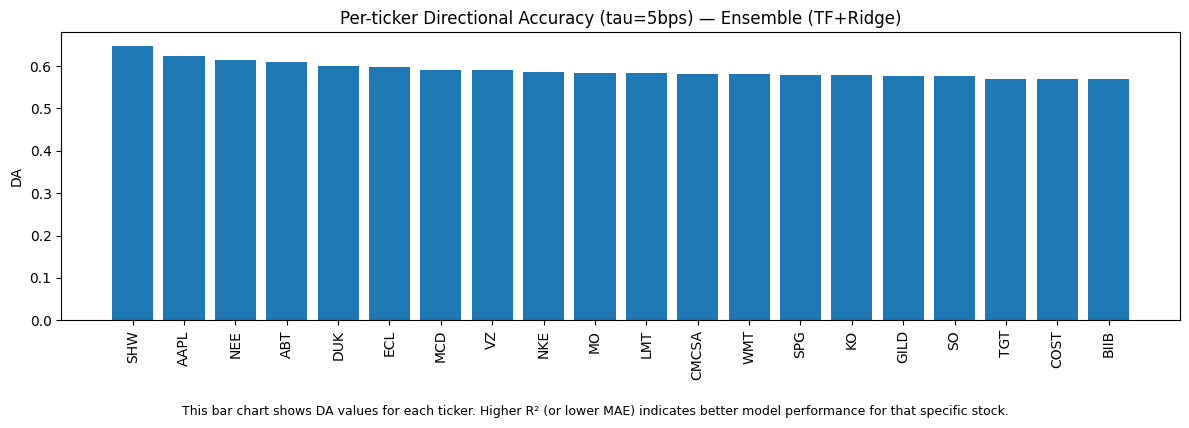

In [ ]:
# ========== 5) Directional Accuracy (per ticker) ==========
def sign_with_band(x, tau=0.0):
    s = np.zeros_like(x, dtype=np.int8)
    s[x>tau]=1; s[x<-tau]=-1
    return s

def DA_per_ticker(y_true, y_pred, tau=0.0005):
    T = y_true.shape[1]; acc = np.zeros(T); cov = np.zeros(T)
    S_true = sign_with_band(y_true, tau)
    for j in range(T):
        m = S_true[:,j]!=0
        cov[j] = m.mean()
        acc[j] = np.nan if not m.any() else (np.sign(y_pred[m,j])==S_true[m,j]).mean()
    return acc, cov

acc, cov = DA_per_ticker(y_te_t, y_pred_use, tau=0.0005)
da_series = pd.Series(acc, index=tickers)
bar_metric(pd.DataFrame({'DA':da_series}).rename_axis('Ticker'), 'DA',
           f'Per-ticker Directional Accuracy (tau=5bps) — {model_label}', 'DA')

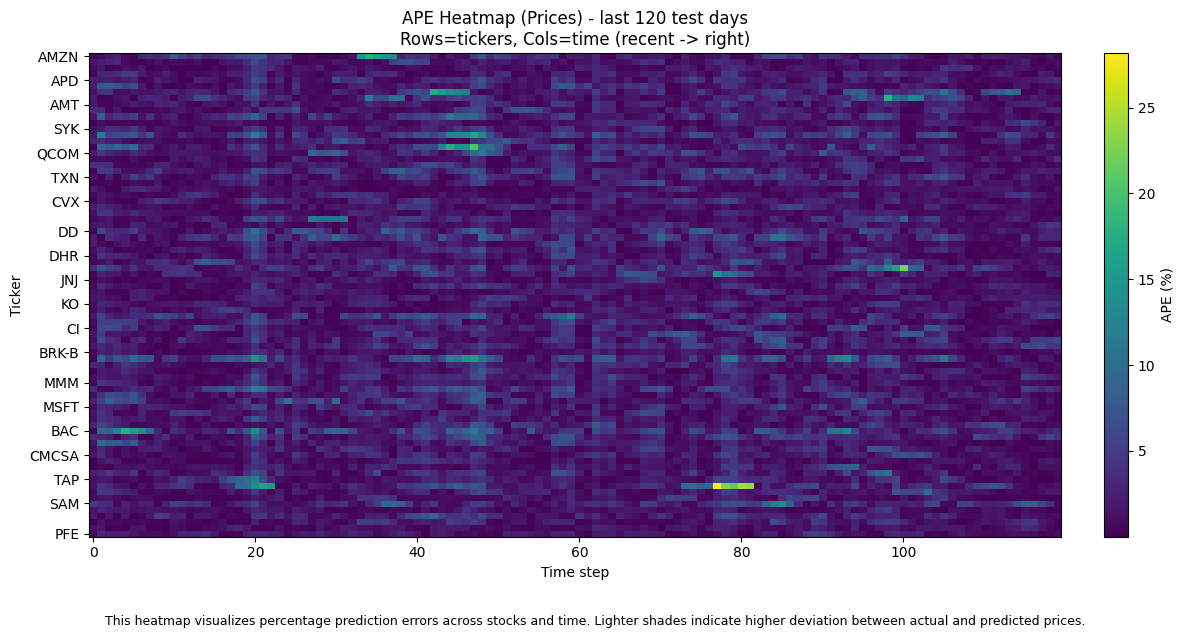

In [ ]:

# ========== 6) Heatmap: per-ticker absolute % error (APE) ==========
def plot_ape_heatmap(last_n=120):
    n = min(last_n, pr_te_t.shape[0])
    true = pr_te_t[-n:, :]
    pred = pr_pred_use[-n:, :]
    ape = np.abs((pred - true) / (true + 1e-12)) * 100.0  # %
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(ape.T, aspect='auto', interpolation='nearest', cmap='viridis')
    plt.title(f'APE Heatmap (Prices) - last {n} test days\nRows=tickers, Cols=time (recent -> right)')
    plt.xlabel('Time step'); plt.ylabel('Ticker')
    yticks = np.linspace(0, len(tickers)-1, num=min(20, len(tickers))).astype(int)
    ax.set_yticks(yticks); ax.set_yticklabels([tickers[i] for i in yticks])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='APE (%)')
    plt.tight_layout()
    plt.figtext(0.5, -0.05,
                f'This heatmap visualizes percentage prediction errors across stocks and time. '
                f'Lighter shades indicate higher deviation between actual and predicted prices.',
                wrap=True, ha='center', fontsize=9)
    plt.show()

plot_ape_heatmap(last_n=120)

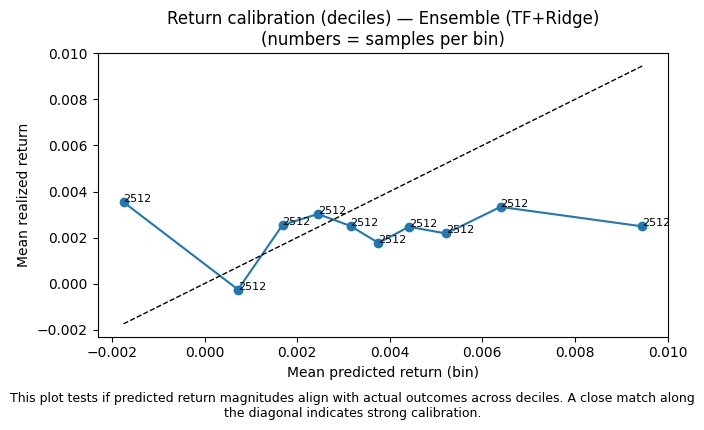

In [ ]:

# ========== 7) Calibration of predicted returns (deciles) ==========
def calibration_deciles(y_true, y_pred, deciles=10, title='Return calibration'):
    yt = y_true.reshape(-1); yp = y_pred.reshape(-1)
    q = np.linspace(0,1,deciles+1)
    edges = np.quantile(yp, q)
    idx = np.digitize(yp, edges[1:-1], right=True)
    df = pd.DataFrame({'yp': yp, 'yt': yt, 'bin': idx})
    grp = df.groupby('bin').agg(pred_mean=('yp','mean'), true_mean=('yt','mean'), count=('yt','size'))
    plt.figure(figsize=(7,4))
    plt.plot(grp['pred_mean'], grp['true_mean'], marker='o')
    lim = [min(grp['pred_mean'].min(), grp['true_mean'].min()),
           max(grp['pred_mean'].max(), grp['true_mean'].max())]
    plt.plot(lim, lim, 'k--', linewidth=1)
    for i,(x,y,c) in enumerate(zip(grp['pred_mean'], grp['true_mean'], grp['count'])):
        plt.text(x, y, str(int(c)), fontsize=8)
    plt.title(f'{title} — {model_label}\n(numbers = samples per bin)')
    plt.xlabel('Mean predicted return (bin)'); plt.ylabel('Mean realized return')
    plt.tight_layout()
    plt.figtext(0.5, -0.05,
                'This plot tests if predicted return magnitudes align with actual outcomes across deciles. '
                'A close match along the diagonal indicates strong calibration.',
                wrap=True, ha='center', fontsize=9)
    plt.show()

calibration_deciles(y_te_t, y_pred_use, deciles=10, title='Return calibration (deciles)')


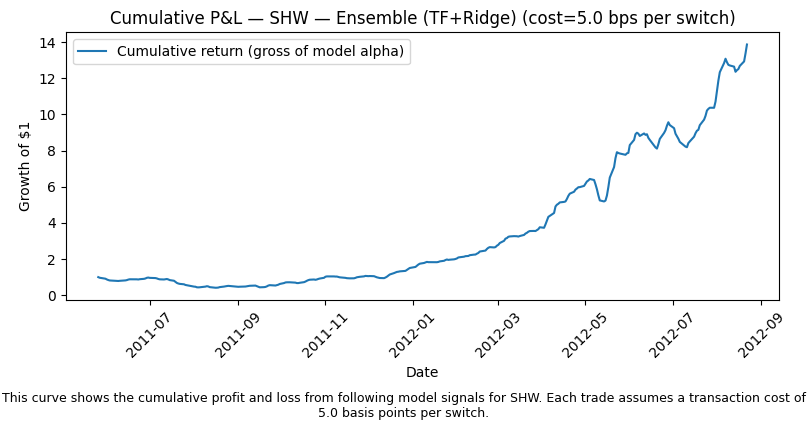

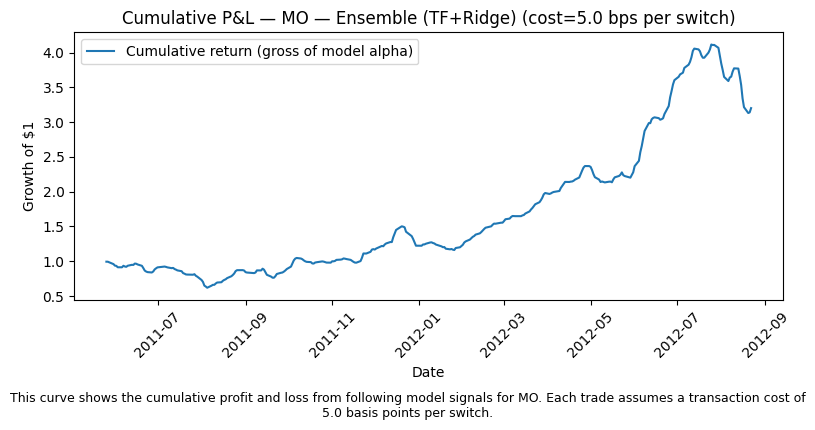

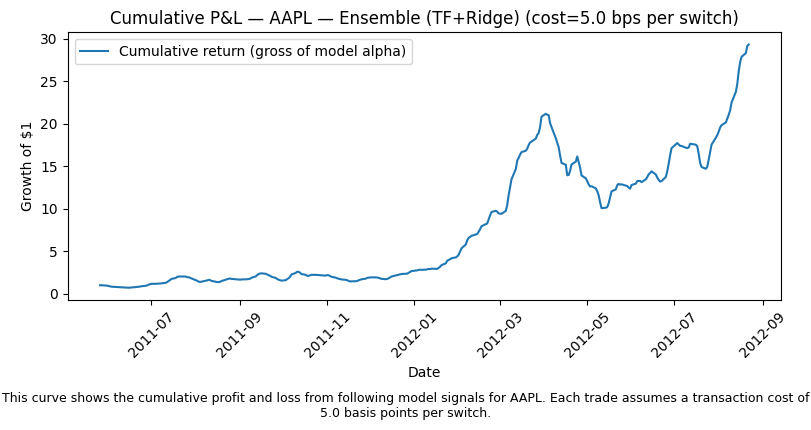

In [ ]:
# ========== 8) Simple long-only P&L from sign (per ticker) ==========
def plot_cum_pnl_for(tk, cost_bps=0.0):
    j = list(tickers).index(tk)
    signal = (y_pred_use[:, j] > 0).astype(float)
    ret = y_te_t[:, j]
    flip = np.r_[0, np.diff(signal)]
    trades = np.abs(flip)
    pnl = signal * ret - trades * (cost_bps/10000.0)
    cum = (1.0 + pnl).cumprod()
    plt.figure(figsize=(8,4))
    plt.plot(dates_test_idx, cum, label='Cumulative return (gross of model alpha)')
    plt.title(f'Cumulative P&L — {tk} — {model_label} (cost={cost_bps} bps per switch)')
    plt.xlabel('Date'); plt.ylabel('Growth of $1'); plt.legend(); plt.xticks(rotation=45); plt.tight_layout()
    plt.figtext(0.5, -0.05,
                f'This curve shows the cumulative profit and loss from following model signals for {tk}. '
                f'Each trade assumes a transaction cost of {cost_bps} basis points per switch.',
                wrap=True, ha='center', fontsize=9)
    plt.show()

for tk in (top3 + bot3)[:3]:
    plot_cum_pnl_for(tk, cost_bps=5.0)

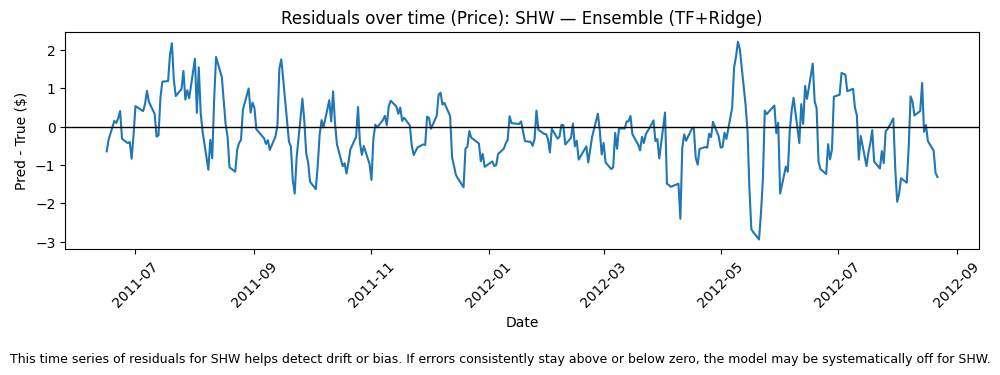

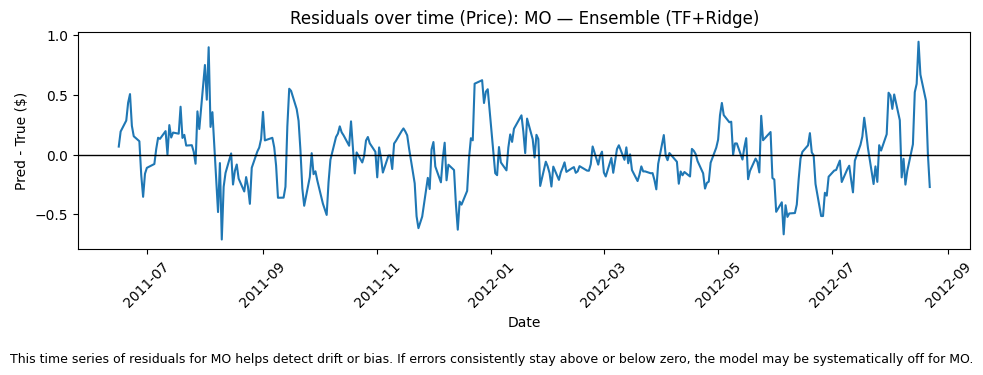

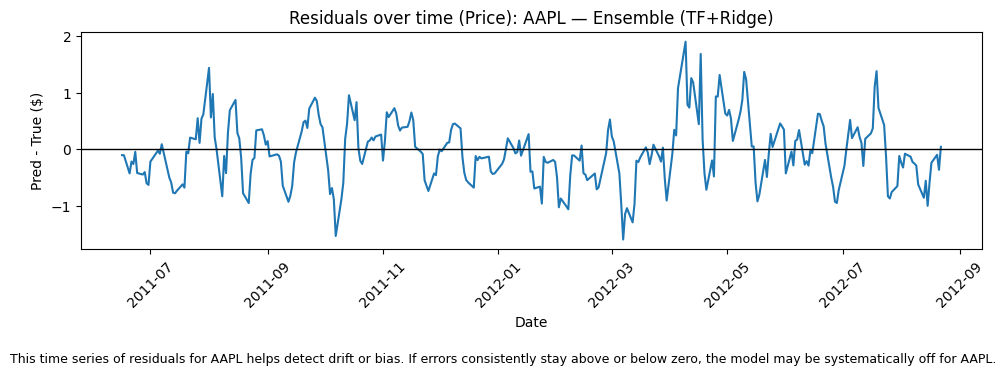

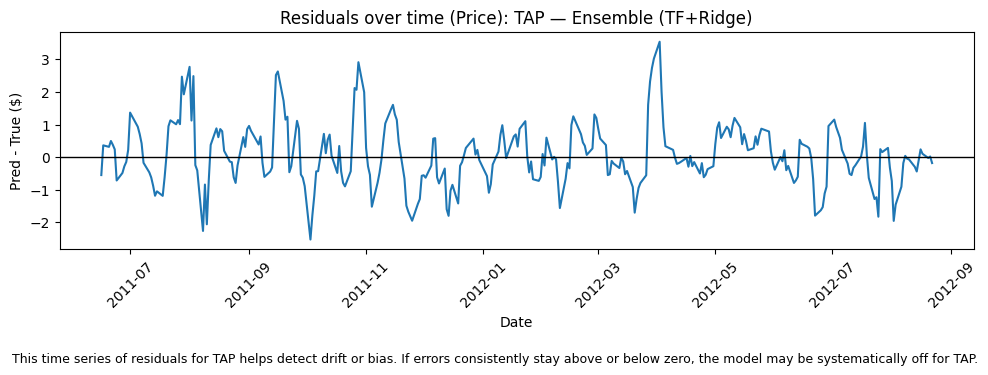

In [ ]:
# ========== 9) Residuals over time (drift check) ==========
def plot_residuals_over_time(tk, last_n=300):
    j = list(tickers).index(tk)
    err = pr_pred_use[:, j] - pr_te_t[:, j]
    if len(err) > last_n:
        err = err[-last_n:]
        dts = dates_test_idx[-last_n:]
    else:
        dts = dates_test_idx
    plt.figure(figsize=(10,3.5))
    plt.plot(dts, err)
    plt.axhline(0, color='k', linewidth=1)
    plt.title(f'Residuals over time (Price): {tk} — {model_label}')
    plt.xlabel('Date'); plt.ylabel('Pred - True ($)')
    plt.xticks(rotation=45); plt.tight_layout()
    plt.figtext(0.5, -0.05,
                f'This time series of residuals for {tk} helps detect drift or bias. '
                f'If errors consistently stay above or below zero, the model may be systematically off for {tk}.',
                wrap=True, ha='center', fontsize=9)
    plt.show()

for tk in (top3 + bot3)[:4]:
    plot_residuals_over_time(tk, last_n=300)

**--------------------------------------------------------------------------**

In [ ]:
import joblib, numpy as np, pickle, torch
joblib.dump(scaler_X, "scaler_X.pkl")              # StandardScaler used for X
joblib.dump(target_scalers, "target_scalers.pkl")  # dict of scalers per ticker
joblib.dump(models_ridge, "ridge_models.pkl")
np.save("ensemble_weights.npy", w_val)             # per-ticker ensemble weights
torch.save(model.state_dict(), "market_transformer.pth")  # transformer weights

import json
with open("tickers.json","w") as f: json.dump(list(tickers), f)
with open("enh_feats.json","w") as f: json.dump(enh_feats, f)
